**时间序列预测前沿算法汇总Ⅱ**

In [121]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.fft as fft
import os
from tqdm import tqdm # 打印进度条
import math
from einops import rearrange, repeat, reduce
from scipy.fftpack import next_fast_len
import matplotlib.pyplot as plt
from functools import partial, reduce, wraps
from sympy import Poly, legendre, Symbol, chebyshevt
from scipy.special import eval_legendre
from scipy import signal
from torch.nn.modules.linear import Linear
from operator import mul

import warnings

warnings.filterwarnings("ignore")

# 基于Crossformer的时间序列预测

## 多变量多步预测

### 数据准备

In [14]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [15]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [16]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [17]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [18]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [19]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型定义

In [34]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]
    
    
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, padding, dropout):
        super(PatchEmbedding, self).__init__()
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch_layer = nn.ReplicationPad1d((0, padding))

        # Backbone, Input encoding: projection of feature vectors onto a d-dim vector space
        self.value_embedding = nn.Linear(patch_len, d_model, bias=False)

        # Positional embedding
        self.position_embedding = PositionalEmbedding(d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # do patching
        n_vars = x.shape[1]
        x = self.padding_patch_layer(x)
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Input encoding
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x), n_vars
    
    
class TwoStageAttentionLayer(nn.Module):
    '''
    The Two Stage Attention (TSA) Layer
    input/output shape: [batch_size, Data_dim(D), Seg_num(L), d_model]
    '''

    def __init__(self, seg_num, factor, d_model, n_heads, output_attention, d_ff=None, dropout=0.1):
        super(TwoStageAttentionLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.time_attention = AttentionLayer(FullAttention(False, factor, attention_dropout=dropout,
                                                           output_attention=output_attention), d_model, n_heads)
        self.dim_sender = AttentionLayer(FullAttention(False, factor, attention_dropout=dropout,
                                                       output_attention=output_attention), d_model, n_heads)
        self.dim_receiver = AttentionLayer(FullAttention(False, factor, attention_dropout=dropout,
                                                         output_attention=output_attention), d_model, n_heads)
        self.router = nn.Parameter(torch.randn(seg_num, factor, d_model))

        self.dropout = nn.Dropout(dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)

        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_ff),
                                  nn.GELU(),
                                  nn.Linear(d_ff, d_model))
        self.MLP2 = nn.Sequential(nn.Linear(d_model, d_ff),
                                  nn.GELU(),
                                  nn.Linear(d_ff, d_model))

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # Cross Time Stage: Directly apply MSA to each dimension
        batch = x.shape[0]
        time_in = rearrange(x, 'b ts_d seg_num d_model -> (b ts_d) seg_num d_model')
        time_enc, attn = self.time_attention(
            time_in, time_in, time_in, attn_mask=None, tau=None, delta=None
        )
        dim_in = time_in + self.dropout(time_enc)
        dim_in = self.norm1(dim_in)
        dim_in = dim_in + self.dropout(self.MLP1(dim_in))
        dim_in = self.norm2(dim_in)

        # Cross Dimension Stage: use a small set of learnable vectors to aggregate and distribute messages to build the D-to-D connection
        dim_send = rearrange(dim_in, '(b ts_d) seg_num d_model -> (b seg_num) ts_d d_model', b=batch)
        batch_router = repeat(self.router, 'seg_num factor d_model -> (repeat seg_num) factor d_model', repeat=batch)
        dim_buffer, attn = self.dim_sender(batch_router, dim_send, dim_send, attn_mask=None, tau=None, delta=None)
        dim_receive, attn = self.dim_receiver(dim_send, dim_buffer, dim_buffer, attn_mask=None, tau=None, delta=None)
        dim_enc = dim_send + self.dropout(dim_receive)
        dim_enc = self.norm3(dim_enc)
        dim_enc = dim_enc + self.dropout(self.MLP2(dim_enc))
        dim_enc = self.norm4(dim_enc)

        final_out = rearrange(dim_enc, '(b seg_num) ts_d d_model -> b ts_d seg_num d_model', b=batch)

        return final_out

    
class SegMerging(nn.Module):
    def __init__(self, d_model, win_size, norm_layer=nn.LayerNorm):
        super().__init__()
        self.d_model = d_model
        self.win_size = win_size
        self.linear_trans = nn.Linear(win_size * d_model, d_model)
        self.norm = norm_layer(win_size * d_model)

    def forward(self, x):
        batch_size, ts_d, seg_num, d_model = x.shape
        pad_num = seg_num % self.win_size
        if pad_num != 0:
            pad_num = self.win_size - pad_num
            x = torch.cat((x, x[:, :, -pad_num:, :]), dim=-2)

        seg_to_merge = []
        for i in range(self.win_size):
            seg_to_merge.append(x[:, :, i::self.win_size, :])
        x = torch.cat(seg_to_merge, -1)

        x = self.norm(x)
        x = self.linear_trans(x)

        return x


class scale_block(nn.Module):
    def __init__(self, win_size, d_model, n_heads, d_ff, depth, dropout, output_attention, 
                 seg_num=10, factor=10):
        super(scale_block, self).__init__()

        if win_size > 1:
            self.merge_layer = SegMerging(d_model, win_size, nn.LayerNorm)
        else:
            self.merge_layer = None

        self.encode_layers = nn.ModuleList()

        for i in range(depth):
            self.encode_layers.append(TwoStageAttentionLayer(seg_num, factor, d_model, n_heads, output_attention, 
                                                             d_ff, dropout))

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        _, ts_dim, _, _ = x.shape

        if self.merge_layer is not None:
            x = self.merge_layer(x)

        for layer in self.encode_layers:
            x = layer(x)

        return x, None


class Encoder(nn.Module):
    def __init__(self, attn_layers):
        super(Encoder, self).__init__()
        self.encode_blocks = nn.ModuleList(attn_layers)

    def forward(self, x):
        encode_x = []
        encode_x.append(x)

        for block in self.encode_blocks:
            x, attns = block(x)
            encode_x.append(x)

        return encode_x, None


class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, seg_len, d_model, d_ff=None, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_model),
                                  nn.GELU(),
                                  nn.Linear(d_model, d_model))
        self.linear_pred = nn.Linear(d_model, seg_len)

    def forward(self, x, cross):
        batch = x.shape[0]
        x = self.self_attention(x)
        x = rearrange(x, 'b ts_d out_seg_num d_model -> (b ts_d) out_seg_num d_model')

        cross = rearrange(cross, 'b ts_d in_seg_num d_model -> (b ts_d) in_seg_num d_model')
        tmp, attn = self.cross_attention(x, cross, cross, None, None, None,)
        x = x + self.dropout(tmp)
        y = x = self.norm1(x)
        y = self.MLP1(y)
        dec_output = self.norm2(x + y)

        dec_output = rearrange(dec_output, '(b ts_d) seg_dec_num d_model -> b ts_d seg_dec_num d_model', b=batch)
        layer_predict = self.linear_pred(dec_output)
        layer_predict = rearrange(layer_predict, 'b out_d seg_num seg_len -> b (out_d seg_num) seg_len')

        return dec_output, layer_predict


class Decoder(nn.Module):
    def __init__(self, layers):
        super(Decoder, self).__init__()
        self.decode_layers = nn.ModuleList(layers)


    def forward(self, x, cross):
        final_predict = None
        i = 0

        ts_d = x.shape[1]
        for layer in self.decode_layers:
            cross_enc = cross[i]
            x, layer_predict = layer(x, cross_enc)
            if final_predict is None:
                final_predict = layer_predict
            else:
                final_predict = final_predict + layer_predict
            i += 1

        final_predict = rearrange(final_predict, 'b (out_d seg_num) seg_len -> b (seg_num seg_len) out_d', out_d=ts_d)

        return final_predict

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
    
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask
    
    
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None
        
        
class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x
    
# Crossformer模型
class Crossformer(nn.Module):
    def __init__(self, enc_in, seq_len, pred_len, e_layers, d_layers, d_model, 
                 output_attention, n_heads, d_ff, dropout, factor):
        super(Crossformer, self).__init__()
        self.enc_in = enc_in
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.seg_len = 12
        self.win_size = 2

        # The padding operation to handle invisible sgemnet length
        self.pad_in_len = math.ceil(1.0 * seq_len / self.seg_len) * self.seg_len
        self.pad_out_len = math.ceil(1.0 * pred_len / self.seg_len) * self.seg_len
        self.in_seg_num = self.pad_in_len // self.seg_len
        self.out_seg_num = math.ceil(self.in_seg_num / (self.win_size ** (e_layers - 1)))
        self.head_nf = d_model * self.out_seg_num

        # Embedding
        self.enc_value_embedding = PatchEmbedding(d_model, self.seg_len, self.seg_len, self.pad_in_len - seq_len, 0)
        self.enc_pos_embedding = nn.Parameter(
            torch.randn(1, enc_in, self.in_seg_num, d_model))
        self.pre_norm = nn.LayerNorm(d_model)

        # Encoder
        self.encoder = Encoder(
            [
                scale_block(1 if l is 0 else self.win_size, d_model, n_heads, d_ff, 1, dropout, output_attention, 
                            self.in_seg_num if l is 0 else math.ceil(self.in_seg_num / self.win_size ** l), factor
                            ) for l in range(e_layers)
            ]
        )
        # Decoder
        self.dec_pos_embedding = nn.Parameter(
            torch.randn(1, enc_in, (self.pad_out_len // self.seg_len), d_model))

        self.decoder = Decoder(
            [
                DecoderLayer(
                    TwoStageAttentionLayer((self.pad_out_len // self.seg_len), factor, d_model, n_heads, output_attention,
                                           d_ff, dropout),
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    self.seg_len,
                    d_model,
                    d_ff,
                    dropout=dropout,
                    # activation=configs.activation,
                )
                for l in range(d_layers + 1)
            ],
        )


    def forward(self, x_enc):
        # embedding
        x_enc, n_vars = self.enc_value_embedding(x_enc.permute(0, 2, 1))
        x_enc = rearrange(x_enc, '(b d) seg_num d_model -> b d seg_num d_model', d = n_vars)
        x_enc += self.enc_pos_embedding
        x_enc = self.pre_norm(x_enc)
        enc_out, attns = self.encoder(x_enc)

        dec_in = repeat(self.dec_pos_embedding, 'b ts_d l d -> (repeat b) ts_d l d', repeat=x_enc.shape[0])
        dec_out = self.decoder(dec_in, enc_out)
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [35]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:31<09:58, 31.53s/it]

Epoch [1/20], Training Loss: 0.0158, Validation Loss: 0.0110
Validation loss decreased (inf --> 0.011013).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [01:01<09:13, 30.76s/it]

Epoch [2/20], Training Loss: 0.0057, Validation Loss: 0.0074
Validation loss decreased (0.011013 --> 0.007376).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [01:32<08:39, 30.54s/it]

Epoch [3/20], Training Loss: 0.0042, Validation Loss: 0.0044
Validation loss decreased (0.007376 --> 0.004405).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [02:02<08:09, 30.61s/it]

Epoch [4/20], Training Loss: 0.0033, Validation Loss: 0.0037
Validation loss decreased (0.004405 --> 0.003723).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [02:33<07:37, 30.51s/it]

Epoch [5/20], Training Loss: 0.0028, Validation Loss: 0.0042
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [03:04<07:10, 30.74s/it]

Epoch [6/20], Training Loss: 0.0025, Validation Loss: 0.0033
Validation loss decreased (0.003723 --> 0.003262).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [03:36<06:44, 31.15s/it]

Epoch [7/20], Training Loss: 0.0023, Validation Loss: 0.0044
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [04:07<06:13, 31.15s/it]

Epoch [8/20], Training Loss: 0.0021, Validation Loss: 0.0032
Validation loss decreased (0.003262 --> 0.003217).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [04:38<05:42, 31.12s/it]

Epoch [9/20], Training Loss: 0.0019, Validation Loss: 0.0033
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [05:09<05:12, 31.20s/it]

Epoch [10/20], Training Loss: 0.0018, Validation Loss: 0.0031
Validation loss decreased (0.003217 --> 0.003125).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [05:41<04:41, 31.30s/it]

Epoch [11/20], Training Loss: 0.0017, Validation Loss: 0.0037
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [06:14<04:14, 31.79s/it]

Epoch [12/20], Training Loss: 0.0016, Validation Loss: 0.0044
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [06:46<03:42, 31.81s/it]

Epoch [13/20], Training Loss: 0.0015, Validation Loss: 0.0031
Validation loss decreased (0.003125 --> 0.003071).  Saving model ...
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [07:16<03:08, 31.49s/it]

Epoch [14/20], Training Loss: 0.0014, Validation Loss: 0.0037
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [07:48<02:37, 31.55s/it]

Epoch [15/20], Training Loss: 0.0014, Validation Loss: 0.0033
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [08:19<02:05, 31.49s/it]

Epoch [16/20], Training Loss: 0.0013, Validation Loss: 0.0029
Validation loss decreased (0.003071 --> 0.002893).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [08:51<01:34, 31.53s/it]

Epoch [17/20], Training Loss: 0.0013, Validation Loss: 0.0032
EarlyStopping counter: 1 out of 7
Updating learning rate to 5.449673790581611e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [09:24<01:03, 31.86s/it]

Epoch [18/20], Training Loss: 0.0013, Validation Loss: 0.0031
EarlyStopping counter: 2 out of 7
Updating learning rate to 2.4471741852423235e-05


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [09:57<00:32, 32.37s/it]

Epoch [19/20], Training Loss: 0.0012, Validation Loss: 0.0031
EarlyStopping counter: 3 out of 7
Updating learning rate to 6.15582970243117e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [10:29<00:00, 31.50s/it]

Epoch [20/20], Training Loss: 0.0012, Validation Loss: 0.0030
EarlyStopping counter: 4 out of 7
Updating learning rate to 0.0


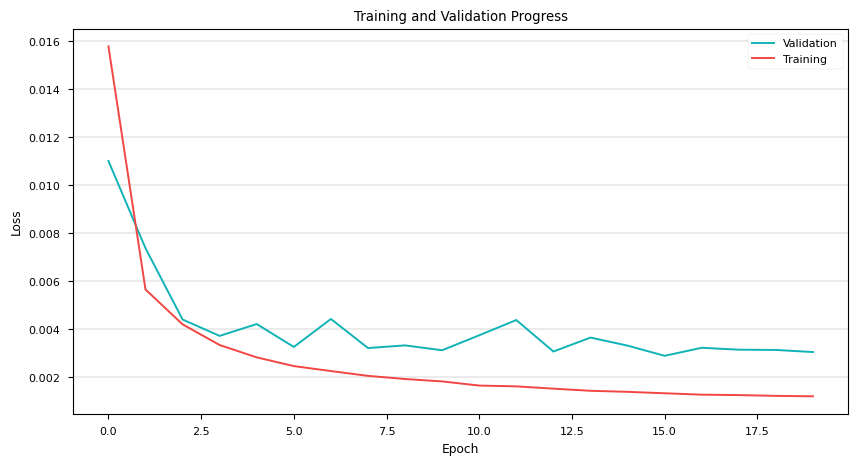

In [37]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load'],
        "features": 'MS'
    },
    "train_args": {
        "model_name": Crossformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 2, 
        'seq_len': 2 * 3,
        'pred_len': 3,
        'output_attention': False,
        'd_model': 32,
        'n_heads': 8,
        'd_ff': 32,
        'dropout': 0.1,
        'e_layers': 1,
        'd_layers': 1,
        'factor': 3
    },
}
model = train(**params3)

# 基于ETSformer的时间序列预测

## 多变量多步预测

### 数据准备

In [13]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [14]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [15]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [16]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [17]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [18]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型定义

In [19]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(
                x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# 编码器和解码器
class Transform:
    def __init__(self, sigma):
        self.sigma = sigma

    @torch.no_grad()
    def transform(self, x):
        return self.jitter(self.shift(self.scale(x)))

    def jitter(self, x):
        return x + (torch.randn(x.shape).to(x.device) * self.sigma)

    def scale(self, x):
        return x * (torch.randn(x.size(-1)).to(x.device) * self.sigma + 1)

    def shift(self, x):
        return x + (torch.randn(x.size(-1)).to(x.device) * self.sigma)


def conv1d_fft(f, g, dim=-1):
    N = f.size(dim)
    M = g.size(dim)

    fast_len = next_fast_len(N + M - 1)

    F_f = fft.rfft(f, fast_len, dim=dim)
    F_g = fft.rfft(g, fast_len, dim=dim)

    F_fg = F_f * F_g.conj()
    out = fft.irfft(F_fg, fast_len, dim=dim)
    out = out.roll((-1,), dims=(dim,))
    idx = torch.as_tensor(range(fast_len - N, fast_len)).to(out.device)
    out = out.index_select(dim, idx)

    return out


class ExponentialSmoothing(nn.Module):

    def __init__(self, dim, nhead, dropout=0.1, aux=False):
        super().__init__()
        self._smoothing_weight = nn.Parameter(torch.randn(nhead, 1))
        self.v0 = nn.Parameter(torch.randn(1, 1, nhead, dim))
        self.dropout = nn.Dropout(dropout)
        if aux:
            self.aux_dropout = nn.Dropout(dropout)

    def forward(self, values, aux_values=None):
        b, t, h, d = values.shape

        init_weight, weight = self.get_exponential_weight(t)
        output = conv1d_fft(self.dropout(values), weight, dim=1)
        output = init_weight * self.v0 + output

        if aux_values is not None:
            aux_weight = weight / (1 - self.weight) * self.weight
            aux_output = conv1d_fft(self.aux_dropout(aux_values), aux_weight)
            output = output + aux_output

        return output

    def get_exponential_weight(self, T):
        # Generate array [0, 1, ..., T-1]
        powers = torch.arange(T, dtype=torch.float, device=self.weight.device)

        # (1 - \alpha) * \alpha^t, for all t = T-1, T-2, ..., 0]
        weight = (1 - self.weight) * (self.weight ** torch.flip(powers, dims=(0,)))

        # \alpha^t for all t = 1, 2, ..., T
        init_weight = self.weight ** (powers + 1)

        return rearrange(init_weight, 'h t -> 1 t h 1'), \
               rearrange(weight, 'h t -> 1 t h 1')

    @property
    def weight(self):
        return torch.sigmoid(self._smoothing_weight)


class Feedforward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1, activation='sigmoid'):
        # Implementation of Feedforward model
        super().__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward, bias=False)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, bias=False)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = getattr(F, activation)

    def forward(self, x):
        x = self.linear2(self.dropout1(self.activation(self.linear1(x))))
        return self.dropout2(x)


class GrowthLayer(nn.Module):

    def __init__(self, d_model, nhead, d_head=None, dropout=0.1):
        super().__init__()
        self.d_head = d_head or (d_model // nhead)
        self.d_model = d_model
        self.nhead = nhead

        self.z0 = nn.Parameter(torch.randn(self.nhead, self.d_head))
        self.in_proj = nn.Linear(self.d_model, self.d_head * self.nhead)
        self.es = ExponentialSmoothing(self.d_head, self.nhead, dropout=dropout)
        self.out_proj = nn.Linear(self.d_head * self.nhead, self.d_model)

        assert self.d_head * self.nhead == self.d_model, "d_model must be divisible by nhead"

    def forward(self, inputs):
        """
        :param inputs: shape: (batch, seq_len, dim)
        :return: shape: (batch, seq_len, dim)
        """
        b, t, d = inputs.shape
        values = self.in_proj(inputs).view(b, t, self.nhead, -1)
        values = torch.cat([repeat(self.z0, 'h d -> b 1 h d', b=b), values], dim=1)
        values = values[:, 1:] - values[:, :-1]
        out = self.es(values)
        out = torch.cat([repeat(self.es.v0, '1 1 h d -> b 1 h d', b=b), out], dim=1)
        out = rearrange(out, 'b t h d -> b t (h d)')
        return self.out_proj(out)


class FourierLayer(nn.Module):

    def __init__(self, d_model, pred_len, k=None, low_freq=1):
        super().__init__()
        self.d_model = d_model
        self.pred_len = pred_len
        self.k = k
        self.low_freq = low_freq

    def forward(self, x):
        """x: (b, t, d)"""
        b, t, d = x.shape
        x_freq = fft.rfft(x, dim=1)

        if t % 2 == 0:
            x_freq = x_freq[:, self.low_freq:-1]
            f = fft.rfftfreq(t)[self.low_freq:-1]
        else:
            x_freq = x_freq[:, self.low_freq:]
            f = fft.rfftfreq(t)[self.low_freq:]

        x_freq, index_tuple = self.topk_freq(x_freq)
        f = repeat(f, 'f -> b f d', b=x_freq.size(0), d=x_freq.size(2))
        f = rearrange(f[index_tuple], 'b f d -> b f () d').to(x_freq.device)

        return self.extrapolate(x_freq, f, t)

    def extrapolate(self, x_freq, f, t):
        x_freq = torch.cat([x_freq, x_freq.conj()], dim=1)
        f = torch.cat([f, -f], dim=1)
        t_val = rearrange(torch.arange(t + self.pred_len, dtype=torch.float),
                          't -> () () t ()').to(x_freq.device)

        amp = rearrange(x_freq.abs() / t, 'b f d -> b f () d')
        phase = rearrange(x_freq.angle(), 'b f d -> b f () d')

        x_time = amp * torch.cos(2 * math.pi * f * t_val + phase)

        return reduce(x_time, 'b f t d -> b t d', 'sum')

    def topk_freq(self, x_freq):
        values, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        mesh_a, mesh_b = torch.meshgrid(torch.arange(x_freq.size(0)), torch.arange(x_freq.size(2)))
        index_tuple = (mesh_a.unsqueeze(1), indices, mesh_b.unsqueeze(1))
        x_freq = x_freq[index_tuple]

        return x_freq, index_tuple


class LevelLayer(nn.Module):

    def __init__(self, d_model, c_out, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.c_out = c_out

        self.es = ExponentialSmoothing(1, self.c_out, dropout=dropout, aux=True)
        self.growth_pred = nn.Linear(self.d_model, self.c_out)
        self.season_pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, level, growth, season):
        b, t, _ = level.shape
        growth = self.growth_pred(growth).view(b, t, self.c_out, 1)
        season = self.season_pred(season).view(b, t, self.c_out, 1)
        growth = growth.view(b, t, self.c_out, 1)
        season = season.view(b, t, self.c_out, 1)
        level = level.view(b, t, self.c_out, 1)
        out = self.es(level - season, aux_values=growth)
        out = rearrange(out, 'b t h d -> b t (h d)')
        return out


class EncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, c_out, seq_len, pred_len, k, dim_feedforward=None, dropout=0.1,
                 activation='sigmoid', layer_norm_eps=1e-5):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.seq_len = seq_len
        self.pred_len = pred_len
        dim_feedforward = dim_feedforward or 4 * d_model
        self.dim_feedforward = dim_feedforward

        self.growth_layer = GrowthLayer(d_model, nhead, dropout=dropout)
        self.seasonal_layer = FourierLayer(d_model, pred_len, k=k)
        self.level_layer = LevelLayer(d_model, c_out, dropout=dropout)

        # Implementation of Feedforward model
        self.ff = Feedforward(d_model, dim_feedforward, dropout=dropout, activation=activation)
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, res, level, attn_mask=None):
        season = self._season_block(res)
        res = res - season[:, :-self.pred_len]
        growth = self._growth_block(res)
        res = self.norm1(res - growth[:, 1:])
        res = self.norm2(res + self.ff(res))

        level = self.level_layer(level, growth[:, :-1], season[:, :-self.pred_len])
        return res, level, growth, season

    def _growth_block(self, x):
        x = self.growth_layer(x)
        return self.dropout1(x)

    def _season_block(self, x):
        x = self.seasonal_layer(x)
        return self.dropout2(x)


class Encoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, res, level, attn_mask=None):
        growths = []
        seasons = []
        for layer in self.layers:
            res, level, growth, season = layer(res, level, attn_mask=None)
            growths.append(growth)
            seasons.append(season)

        return level, growths, seasons


class DampingLayer(nn.Module):

    def __init__(self, pred_len, nhead, dropout=0.1):
        super().__init__()
        self.pred_len = pred_len
        self.nhead = nhead
        self._damping_factor = nn.Parameter(torch.randn(1, nhead))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = repeat(x, 'b 1 d -> b t d', t=self.pred_len)
        b, t, d = x.shape

        powers = torch.arange(self.pred_len).to(self._damping_factor.device) + 1
        powers = powers.view(self.pred_len, 1)
        damping_factors = self.damping_factor ** powers
        damping_factors = damping_factors.cumsum(dim=0)
        x = x.view(b, t, self.nhead, -1)
        x = self.dropout(x) * damping_factors.unsqueeze(-1)
        return x.view(b, t, d)

    @property
    def damping_factor(self):
        return torch.sigmoid(self._damping_factor)


class DecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, c_out, pred_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.pred_len = pred_len

        self.growth_damping = DampingLayer(pred_len, nhead, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, growth, season):
        growth_horizon = self.growth_damping(growth[:, -1:])
        growth_horizon = self.dropout1(growth_horizon)

        seasonal_horizon = season[:, -self.pred_len:]
        return growth_horizon, seasonal_horizon


class Decoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.d_model = layers[0].d_model
        self.c_out = layers[0].c_out
        self.pred_len = layers[0].pred_len
        self.nhead = layers[0].nhead

        self.layers = nn.ModuleList(layers)
        self.pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, growths, seasons):
        growth_repr = []
        season_repr = []

        for idx, layer in enumerate(self.layers):
            growth_horizon, season_horizon = layer(growths[idx], seasons[idx])
            growth_repr.append(growth_horizon)
            season_repr.append(season_horizon)
        growth_repr = sum(growth_repr)
        season_repr = sum(season_repr)
        return self.pred(growth_repr), self.pred(season_repr)

    
# ETSformer模型
class ETSformer(nn.Module):
    def __init__(self, seq_len, pred_len, e_layers, d_layers, enc_in, d_model, 
                 dropout, n_heads, top_k, d_ff, c_out):
        super(ETSformer, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        assert e_layers == d_layers, "Encoder and decoder layers must be equal"

        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    d_model, n_heads, enc_in, seq_len, pred_len, top_k,
                    dim_feedforward=d_ff,
                    dropout=dropout,
                    activation='relu',
                ) for _ in range(e_layers)
            ]
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    d_model, n_heads, c_out, pred_len,
                    dropout=dropout,
                ) for _ in range(d_layers)
            ],
        )
        self.transform = Transform(sigma=0.2)

    def forward(self, x_enc, x_mark_enc=None):
        with torch.no_grad():
            if self.training:
                x_enc = self.transform.transform(x_enc)
#         x_enc = self.transform.transform(x_enc)
        res = self.enc_embedding(x_enc, x_mark_enc)
        level, growths, seasons = self.encoder(res, x_enc, attn_mask=None)

        growth, season = self.decoder(growths, seasons)
        dec_out = level[:, -1:] + growth + season
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [20]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:30<09:36, 30.37s/it]

Epoch [1/20], Training Loss: 0.0563, Validation Loss: 0.0322
Validation loss decreased (inf --> 0.032186).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [01:02<09:20, 31.12s/it]

Epoch [2/20], Training Loss: 0.0354, Validation Loss: 0.0269
Validation loss decreased (0.032186 --> 0.026853).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [01:31<08:36, 30.37s/it]

Epoch [3/20], Training Loss: 0.0338, Validation Loss: 0.0271
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [02:00<07:59, 29.94s/it]

Epoch [4/20], Training Loss: 0.0329, Validation Loss: 0.0220
Validation loss decreased (0.026853 --> 0.021952).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [02:29<07:19, 29.33s/it]

Epoch [5/20], Training Loss: 0.0321, Validation Loss: 0.0255
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [02:59<06:53, 29.56s/it]

Epoch [6/20], Training Loss: 0.0315, Validation Loss: 0.0264
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [03:29<06:27, 29.77s/it]

Epoch [7/20], Training Loss: 0.0310, Validation Loss: 0.0254
EarlyStopping counter: 3 out of 7
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [04:00<06:01, 30.10s/it]

Epoch [8/20], Training Loss: 0.0299, Validation Loss: 0.0318
EarlyStopping counter: 4 out of 7
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [04:29<05:29, 29.93s/it]

Epoch [9/20], Training Loss: 0.0302, Validation Loss: 0.0264
EarlyStopping counter: 5 out of 7
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [04:58<04:56, 29.67s/it]

Epoch [10/20], Training Loss: 0.0295, Validation Loss: 0.0286
EarlyStopping counter: 6 out of 7
Updating learning rate to 0.0005


 50%|█████████████████████████████████████████                                         | 10/20 [05:27<05:27, 32.76s/it]

Epoch [11/20], Training Loss: 0.0291, Validation Loss: 0.0276
EarlyStopping counter: 7 out of 7
Early stopping!


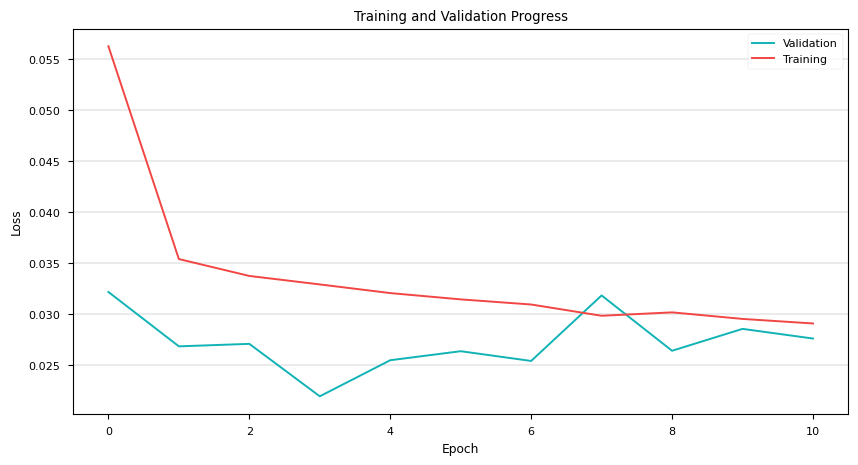

In [21]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load'],
        "features": 'MS'
    },
    "train_args": {
        "model_name": ETSformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 2, 
        'seq_len': 2 * 3,
        'pred_len': 3,
        'top_k': 2,
        'd_model': 128,
        'n_heads': 8,
        'd_ff': 128,
        'dropout': 0.1,
        'e_layers': 1,
        'd_layers': 1,
        'c_out': 1
    },
}
model = train(**params3)

# 基于FEDformer的时间序列预测

## 多变量多步预测

### 数据准备

In [27]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [28]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [29]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [30]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [31]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [32]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型定义

In [39]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# AutoCorrelationLayer类
class AutoCorrelation(nn.Module):
    """
    AutoCorrelation Mechanism with the following two phases:
    (1) period-based dependencies discovery
    (2) time delay aggregation
    This block can replace the self-attention family mechanism seamlessly.
    """

    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def time_delay_agg_training(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the training phase.
        """
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the inference phase.
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(batch, head, channel, 1).cuda()
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        weights, delay = torch.topk(mean_value, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_full(self, values, corr):
        """
        Standard version of Autocorrelation
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(batch, head, channel, 1).cuda()
        # find top k
        top_k = int(self.factor * math.log(length))
        weights, delay = torch.topk(corr, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[..., i].unsqueeze(-1)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * (tmp_corr[..., i].unsqueeze(-1))
        return delays_agg

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]

        # period-based dependencies
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)

        # time delay agg
        if self.training:
            V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        else:
            V = self.time_delay_agg_inference(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)


class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AutoCorrelationLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_correlation = correlation
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_correlation(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
    
# 傅里叶层
def get_frequency_modes(seq_len, modes=64, mode_select_method='random'):
    """
    get modes on frequency domain:
    'random' means sampling randomly;
    'else' means sampling the lowest modes;
    """
    modes = min(modes, seq_len // 2)
    if mode_select_method == 'random':
        index = list(range(0, seq_len // 2))
        np.random.shuffle(index)
        index = index[:modes]
    else:
        index = list(range(0, modes))
    index.sort()
    return index


# ########## fourier layer #############
class FourierBlock(nn.Module):
    def __init__(self, in_channels, out_channels, seq_len, modes=0, mode_select_method='random'):
        super(FourierBlock, self).__init__()
        print('fourier enhanced block used!')
        """
        1D Fourier block. It performs representation learning on frequency domain, 
        it does FFT, linear transform, and Inverse FFT.    
        """
        # get modes on frequency domain
        self.index = get_frequency_modes(seq_len, modes=modes, mode_select_method=mode_select_method)
        print('modes={}, index={}'.format(modes, self.index))

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(8, in_channels // 8, out_channels // 8, len(self.index), dtype=torch.float))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(8, in_channels // 8, out_channels // 8, len(self.index), dtype=torch.float))

    # Complex multiplication
    def compl_mul1d(self, order, x, weights):
        x_flag = True
        w_flag = True
        if not torch.is_complex(x):
            x_flag = False
            x = torch.complex(x, torch.zeros_like(x).to(x.device))
        if not torch.is_complex(weights):
            w_flag = False
            weights = torch.complex(weights, torch.zeros_like(weights).to(weights.device))
        if x_flag or w_flag:
            return torch.complex(torch.einsum(order, x.real, weights.real) - torch.einsum(order, x.imag, weights.imag),
                                 torch.einsum(order, x.real, weights.imag) + torch.einsum(order, x.imag, weights.real))
        else:
            return torch.einsum(order, x.real, weights.real)

    def forward(self, q, k, v, mask):
        # size = [B, L, H, E]
        B, L, H, E = q.shape
        x = q.permute(0, 2, 3, 1)
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x, dim=-1)
        # Perform Fourier neural operations
        out_ft = torch.zeros(B, H, E, L // 2 + 1, device=x.device, dtype=torch.cfloat)
        for wi, i in enumerate(self.index):
            if i >= x_ft.shape[3] or wi >= out_ft.shape[3]:
                continue
            out_ft[:, :, :, wi] = self.compl_mul1d("bhi,hio->bho", x_ft[:, :, :, i],
                                                   torch.complex(self.weights1, self.weights2)[:, :, :, wi])
        # Return to time domain
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return (x, None)


# ########## Fourier Cross Former ####################
class FourierCrossAttention(nn.Module):
    def __init__(self, in_channels, out_channels, seq_len_q, seq_len_kv, modes=64, mode_select_method='random',
                 activation='tanh', policy=0, num_heads=8):
        super(FourierCrossAttention, self).__init__()
        print('fourier enhanced cross attention used!')
        """
        1D Fourier Cross Attention layer. It does FFT, linear transform, attention mechanism and Inverse FFT.    
        """
        self.activation = activation
        self.in_channels = in_channels
        self.out_channels = out_channels
        # get modes for queries and keys (& values) on frequency domain
        self.index_q = get_frequency_modes(seq_len_q, modes=modes, mode_select_method=mode_select_method)
        self.index_kv = get_frequency_modes(seq_len_kv, modes=modes, mode_select_method=mode_select_method)

        print('modes_q={}, index_q={}'.format(len(self.index_q), self.index_q))
        print('modes_kv={}, index_kv={}'.format(len(self.index_kv), self.index_kv))

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(num_heads, in_channels // num_heads, out_channels // num_heads, len(self.index_q), dtype=torch.float))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(num_heads, in_channels // num_heads, out_channels // num_heads, len(self.index_q), dtype=torch.float))

    # Complex multiplication
    def compl_mul1d(self, order, x, weights):
        x_flag = True
        w_flag = True
        if not torch.is_complex(x):
            x_flag = False
            x = torch.complex(x, torch.zeros_like(x).to(x.device))
        if not torch.is_complex(weights):
            w_flag = False
            weights = torch.complex(weights, torch.zeros_like(weights).to(weights.device))
        if x_flag or w_flag:
            return torch.complex(torch.einsum(order, x.real, weights.real) - torch.einsum(order, x.imag, weights.imag),
                                 torch.einsum(order, x.real, weights.imag) + torch.einsum(order, x.imag, weights.real))
        else:
            return torch.einsum(order, x.real, weights.real)

    def forward(self, q, k, v, mask):
        # size = [B, L, H, E]
        B, L, H, E = q.shape
        xq = q.permute(0, 2, 3, 1)  # size = [B, H, E, L]
        xk = k.permute(0, 2, 3, 1)
        xv = v.permute(0, 2, 3, 1)

        # Compute Fourier coefficients
        xq_ft_ = torch.zeros(B, H, E, len(self.index_q), device=xq.device, dtype=torch.cfloat)
        xq_ft = torch.fft.rfft(xq, dim=-1)
        for i, j in enumerate(self.index_q):
            if j >= xq_ft.shape[3]:
                continue
            xq_ft_[:, :, :, i] = xq_ft[:, :, :, j]
        xk_ft_ = torch.zeros(B, H, E, len(self.index_kv), device=xq.device, dtype=torch.cfloat)
        xk_ft = torch.fft.rfft(xk, dim=-1)
        for i, j in enumerate(self.index_kv):
            if j >= xk_ft.shape[3]:
                continue
            xk_ft_[:, :, :, i] = xk_ft[:, :, :, j]

        # perform attention mechanism on frequency domain
        xqk_ft = (self.compl_mul1d("bhex,bhey->bhxy", xq_ft_, xk_ft_))
        if self.activation == 'tanh':
            xqk_ft = torch.complex(xqk_ft.real.tanh(), xqk_ft.imag.tanh())
        elif self.activation == 'softmax':
            xqk_ft = torch.softmax(abs(xqk_ft), dim=-1)
            xqk_ft = torch.complex(xqk_ft, torch.zeros_like(xqk_ft))
        else:
            raise Exception('{} actiation function is not implemented'.format(self.activation))
        xqkv_ft = self.compl_mul1d("bhxy,bhey->bhex", xqk_ft, xk_ft_)
        xqkvw = self.compl_mul1d("bhex,heox->bhox", xqkv_ft, torch.complex(self.weights1, self.weights2))
        out_ft = torch.zeros(B, H, E, L // 2 + 1, device=xq.device, dtype=torch.cfloat)
        for i, j in enumerate(self.index_q):
            if i >= xqkvw.shape[3] or j >= out_ft.shape[3]:
                continue
            out_ft[:, :, :, j] = xqkvw[:, :, :, i]
        # Return to time domain
        out = torch.fft.irfft(out_ft / self.in_channels / self.out_channels, n=xq.size(-1))
        return (out, None)
    

# MultiWaveletCorrelation类
def legendreDer(k, x):
    def _legendre(k, x):
        return (2 * k + 1) * eval_legendre(k, x)

    out = 0
    for i in np.arange(k - 1, -1, -2):
        out += _legendre(i, x)
    return out


def phi_(phi_c, x, lb=0, ub=1):
    mask = np.logical_or(x < lb, x > ub) * 1.0
    return np.polynomial.polynomial.Polynomial(phi_c)(x) * (1 - mask)


def get_phi_psi(k, base):
    x = Symbol('x')
    phi_coeff = np.zeros((k, k))
    phi_2x_coeff = np.zeros((k, k))
    if base == 'legendre':
        for ki in range(k):
            coeff_ = Poly(legendre(ki, 2 * x - 1), x).all_coeffs()
            phi_coeff[ki, :ki + 1] = np.flip(np.sqrt(2 * ki + 1) * np.array(coeff_).astype(np.float64))
            coeff_ = Poly(legendre(ki, 4 * x - 1), x).all_coeffs()
            phi_2x_coeff[ki, :ki + 1] = np.flip(np.sqrt(2) * np.sqrt(2 * ki + 1) * np.array(coeff_).astype(np.float64))

        psi1_coeff = np.zeros((k, k))
        psi2_coeff = np.zeros((k, k))
        for ki in range(k):
            psi1_coeff[ki, :] = phi_2x_coeff[ki, :]
            for i in range(k):
                a = phi_2x_coeff[ki, :ki + 1]
                b = phi_coeff[i, :i + 1]
                prod_ = np.convolve(a, b)
                prod_[np.abs(prod_) < 1e-8] = 0
                proj_ = (prod_ * 1 / (np.arange(len(prod_)) + 1) * np.power(0.5, 1 + np.arange(len(prod_)))).sum()
                psi1_coeff[ki, :] -= proj_ * phi_coeff[i, :]
                psi2_coeff[ki, :] -= proj_ * phi_coeff[i, :]
            for j in range(ki):
                a = phi_2x_coeff[ki, :ki + 1]
                b = psi1_coeff[j, :]
                prod_ = np.convolve(a, b)
                prod_[np.abs(prod_) < 1e-8] = 0
                proj_ = (prod_ * 1 / (np.arange(len(prod_)) + 1) * np.power(0.5, 1 + np.arange(len(prod_)))).sum()
                psi1_coeff[ki, :] -= proj_ * psi1_coeff[j, :]
                psi2_coeff[ki, :] -= proj_ * psi2_coeff[j, :]

            a = psi1_coeff[ki, :]
            prod_ = np.convolve(a, a)
            prod_[np.abs(prod_) < 1e-8] = 0
            norm1 = (prod_ * 1 / (np.arange(len(prod_)) + 1) * np.power(0.5, 1 + np.arange(len(prod_)))).sum()

            a = psi2_coeff[ki, :]
            prod_ = np.convolve(a, a)
            prod_[np.abs(prod_) < 1e-8] = 0
            norm2 = (prod_ * 1 / (np.arange(len(prod_)) + 1) * (1 - np.power(0.5, 1 + np.arange(len(prod_))))).sum()
            norm_ = np.sqrt(norm1 + norm2)
            psi1_coeff[ki, :] /= norm_
            psi2_coeff[ki, :] /= norm_
            psi1_coeff[np.abs(psi1_coeff) < 1e-8] = 0
            psi2_coeff[np.abs(psi2_coeff) < 1e-8] = 0

        phi = [np.poly1d(np.flip(phi_coeff[i, :])) for i in range(k)]
        psi1 = [np.poly1d(np.flip(psi1_coeff[i, :])) for i in range(k)]
        psi2 = [np.poly1d(np.flip(psi2_coeff[i, :])) for i in range(k)]

    elif base == 'chebyshev':
        for ki in range(k):
            if ki == 0:
                phi_coeff[ki, :ki + 1] = np.sqrt(2 / np.pi)
                phi_2x_coeff[ki, :ki + 1] = np.sqrt(2 / np.pi) * np.sqrt(2)
            else:
                coeff_ = Poly(chebyshevt(ki, 2 * x - 1), x).all_coeffs()
                phi_coeff[ki, :ki + 1] = np.flip(2 / np.sqrt(np.pi) * np.array(coeff_).astype(np.float64))
                coeff_ = Poly(chebyshevt(ki, 4 * x - 1), x).all_coeffs()
                phi_2x_coeff[ki, :ki + 1] = np.flip(
                    np.sqrt(2) * 2 / np.sqrt(np.pi) * np.array(coeff_).astype(np.float64))

        phi = [partial(phi_, phi_coeff[i, :]) for i in range(k)]

        x = Symbol('x')
        kUse = 2 * k
        roots = Poly(chebyshevt(kUse, 2 * x - 1)).all_roots()
        x_m = np.array([rt.evalf(20) for rt in roots]).astype(np.float64)
        # x_m[x_m==0.5] = 0.5 + 1e-8 # add small noise to avoid the case of 0.5 belonging to both phi(2x) and phi(2x-1)
        # not needed for our purpose here, we use even k always to avoid
        wm = np.pi / kUse / 2

        psi1_coeff = np.zeros((k, k))
        psi2_coeff = np.zeros((k, k))

        psi1 = [[] for _ in range(k)]
        psi2 = [[] for _ in range(k)]

        for ki in range(k):
            psi1_coeff[ki, :] = phi_2x_coeff[ki, :]
            for i in range(k):
                proj_ = (wm * phi[i](x_m) * np.sqrt(2) * phi[ki](2 * x_m)).sum()
                psi1_coeff[ki, :] -= proj_ * phi_coeff[i, :]
                psi2_coeff[ki, :] -= proj_ * phi_coeff[i, :]

            for j in range(ki):
                proj_ = (wm * psi1[j](x_m) * np.sqrt(2) * phi[ki](2 * x_m)).sum()
                psi1_coeff[ki, :] -= proj_ * psi1_coeff[j, :]
                psi2_coeff[ki, :] -= proj_ * psi2_coeff[j, :]

            psi1[ki] = partial(phi_, psi1_coeff[ki, :], lb=0, ub=0.5)
            psi2[ki] = partial(phi_, psi2_coeff[ki, :], lb=0.5, ub=1)

            norm1 = (wm * psi1[ki](x_m) * psi1[ki](x_m)).sum()
            norm2 = (wm * psi2[ki](x_m) * psi2[ki](x_m)).sum()

            norm_ = np.sqrt(norm1 + norm2)
            psi1_coeff[ki, :] /= norm_
            psi2_coeff[ki, :] /= norm_
            psi1_coeff[np.abs(psi1_coeff) < 1e-8] = 0
            psi2_coeff[np.abs(psi2_coeff) < 1e-8] = 0

            psi1[ki] = partial(phi_, psi1_coeff[ki, :], lb=0, ub=0.5 + 1e-16)
            psi2[ki] = partial(phi_, psi2_coeff[ki, :], lb=0.5 + 1e-16, ub=1)

    return phi, psi1, psi2


def get_filter(base, k):
    def psi(psi1, psi2, i, inp):
        mask = (inp <= 0.5) * 1.0
        return psi1[i](inp) * mask + psi2[i](inp) * (1 - mask)

    if base not in ['legendre', 'chebyshev']:
        raise Exception('Base not supported')

    x = Symbol('x')
    H0 = np.zeros((k, k))
    H1 = np.zeros((k, k))
    G0 = np.zeros((k, k))
    G1 = np.zeros((k, k))
    PHI0 = np.zeros((k, k))
    PHI1 = np.zeros((k, k))
    phi, psi1, psi2 = get_phi_psi(k, base)
    if base == 'legendre':
        roots = Poly(legendre(k, 2 * x - 1)).all_roots()
        x_m = np.array([rt.evalf(20) for rt in roots]).astype(np.float64)
        wm = 1 / k / legendreDer(k, 2 * x_m - 1) / eval_legendre(k - 1, 2 * x_m - 1)

        for ki in range(k):
            for kpi in range(k):
                H0[ki, kpi] = 1 / np.sqrt(2) * (wm * phi[ki](x_m / 2) * phi[kpi](x_m)).sum()
                G0[ki, kpi] = 1 / np.sqrt(2) * (wm * psi(psi1, psi2, ki, x_m / 2) * phi[kpi](x_m)).sum()
                H1[ki, kpi] = 1 / np.sqrt(2) * (wm * phi[ki]((x_m + 1) / 2) * phi[kpi](x_m)).sum()
                G1[ki, kpi] = 1 / np.sqrt(2) * (wm * psi(psi1, psi2, ki, (x_m + 1) / 2) * phi[kpi](x_m)).sum()

        PHI0 = np.eye(k)
        PHI1 = np.eye(k)

    elif base == 'chebyshev':
        x = Symbol('x')
        kUse = 2 * k
        roots = Poly(chebyshevt(kUse, 2 * x - 1)).all_roots()
        x_m = np.array([rt.evalf(20) for rt in roots]).astype(np.float64)
        # x_m[x_m==0.5] = 0.5 + 1e-8 # add small noise to avoid the case of 0.5 belonging to both phi(2x) and phi(2x-1)
        # not needed for our purpose here, we use even k always to avoid
        wm = np.pi / kUse / 2

        for ki in range(k):
            for kpi in range(k):
                H0[ki, kpi] = 1 / np.sqrt(2) * (wm * phi[ki](x_m / 2) * phi[kpi](x_m)).sum()
                G0[ki, kpi] = 1 / np.sqrt(2) * (wm * psi(psi1, psi2, ki, x_m / 2) * phi[kpi](x_m)).sum()
                H1[ki, kpi] = 1 / np.sqrt(2) * (wm * phi[ki]((x_m + 1) / 2) * phi[kpi](x_m)).sum()
                G1[ki, kpi] = 1 / np.sqrt(2) * (wm * psi(psi1, psi2, ki, (x_m + 1) / 2) * phi[kpi](x_m)).sum()

                PHI0[ki, kpi] = (wm * phi[ki](2 * x_m) * phi[kpi](2 * x_m)).sum() * 2
                PHI1[ki, kpi] = (wm * phi[ki](2 * x_m - 1) * phi[kpi](2 * x_m - 1)).sum() * 2

        PHI0[np.abs(PHI0) < 1e-8] = 0
        PHI1[np.abs(PHI1) < 1e-8] = 0

    H0[np.abs(H0) < 1e-8] = 0
    H1[np.abs(H1) < 1e-8] = 0
    G0[np.abs(G0) < 1e-8] = 0
    G1[np.abs(G1) < 1e-8] = 0

    return H0, H1, G0, G1, PHI0, PHI1


class MultiWaveletTransform(nn.Module):
    """
    1D multiwavelet block.
    """

    def __init__(self, ich=1, k=8, alpha=16, c=128,
                 nCZ=1, L=0, base='legendre', attention_dropout=0.1):
        super(MultiWaveletTransform, self).__init__()
        print('base', base)
        self.k = k
        self.c = c
        self.L = L
        self.nCZ = nCZ
        self.Lk0 = nn.Linear(ich, c * k)
        self.Lk1 = nn.Linear(c * k, ich)
        self.ich = ich
        self.MWT_CZ = nn.ModuleList(MWT_CZ1d(k, alpha, L, c, base) for i in range(nCZ))

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]
        values = values.view(B, L, -1)

        V = self.Lk0(values).view(B, L, self.c, -1)
        for i in range(self.nCZ):
            V = self.MWT_CZ[i](V)
            if i < self.nCZ - 1:
                V = F.relu(V)

        V = self.Lk1(V.view(B, L, -1))
        V = V.view(B, L, -1, D)
        return (V.contiguous(), None)


class MultiWaveletCross(nn.Module):
    """
    1D Multiwavelet Cross Attention layer.
    """

    def __init__(self, in_channels, out_channels, seq_len_q, seq_len_kv, modes, c=64,
                 k=8, ich=512,
                 L=0,
                 base='legendre',
                 mode_select_method='random',
                 initializer=None, activation='tanh',
                 **kwargs):
        super(MultiWaveletCross, self).__init__()
        print('base', base)

        self.c = c
        self.k = k
        self.L = L
        H0, H1, G0, G1, PHI0, PHI1 = get_filter(base, k)
        H0r = H0 @ PHI0
        G0r = G0 @ PHI0
        H1r = H1 @ PHI1
        G1r = G1 @ PHI1

        H0r[np.abs(H0r) < 1e-8] = 0
        H1r[np.abs(H1r) < 1e-8] = 0
        G0r[np.abs(G0r) < 1e-8] = 0
        G1r[np.abs(G1r) < 1e-8] = 0
        self.max_item = 3

        self.attn1 = FourierCrossAttentionW(in_channels=in_channels, out_channels=out_channels, seq_len_q=seq_len_q,
                                            seq_len_kv=seq_len_kv, modes=modes, activation=activation,
                                            mode_select_method=mode_select_method)
        self.attn2 = FourierCrossAttentionW(in_channels=in_channels, out_channels=out_channels, seq_len_q=seq_len_q,
                                            seq_len_kv=seq_len_kv, modes=modes, activation=activation,
                                            mode_select_method=mode_select_method)
        self.attn3 = FourierCrossAttentionW(in_channels=in_channels, out_channels=out_channels, seq_len_q=seq_len_q,
                                            seq_len_kv=seq_len_kv, modes=modes, activation=activation,
                                            mode_select_method=mode_select_method)
        self.attn4 = FourierCrossAttentionW(in_channels=in_channels, out_channels=out_channels, seq_len_q=seq_len_q,
                                            seq_len_kv=seq_len_kv, modes=modes, activation=activation,
                                            mode_select_method=mode_select_method)
        self.T0 = nn.Linear(k, k)
        self.register_buffer('ec_s', torch.Tensor(
            np.concatenate((H0.T, H1.T), axis=0)))
        self.register_buffer('ec_d', torch.Tensor(
            np.concatenate((G0.T, G1.T), axis=0)))

        self.register_buffer('rc_e', torch.Tensor(
            np.concatenate((H0r, G0r), axis=0)))
        self.register_buffer('rc_o', torch.Tensor(
            np.concatenate((H1r, G1r), axis=0)))

        self.Lk = nn.Linear(ich, c * k)
        self.Lq = nn.Linear(ich, c * k)
        self.Lv = nn.Linear(ich, c * k)
        self.out = nn.Linear(c * k, ich)
        self.modes1 = modes

    def forward(self, q, k, v, mask=None):
        B, N, H, E = q.shape  # (B, N, H, E) torch.Size([3, 768, 8, 2])
        _, S, _, _ = k.shape  # (B, S, H, E) torch.Size([3, 96, 8, 2])

        q = q.view(q.shape[0], q.shape[1], -1)
        k = k.view(k.shape[0], k.shape[1], -1)
        v = v.view(v.shape[0], v.shape[1], -1)
        q = self.Lq(q)
        q = q.view(q.shape[0], q.shape[1], self.c, self.k)
        k = self.Lk(k)
        k = k.view(k.shape[0], k.shape[1], self.c, self.k)
        v = self.Lv(v)
        v = v.view(v.shape[0], v.shape[1], self.c, self.k)

        if N > S:
            zeros = torch.zeros_like(q[:, :(N - S), :]).float()
            v = torch.cat([v, zeros], dim=1)
            k = torch.cat([k, zeros], dim=1)
        else:
            v = v[:, :N, :, :]
            k = k[:, :N, :, :]

        ns = math.floor(np.log2(N))
        nl = pow(2, math.ceil(np.log2(N)))
        extra_q = q[:, 0:nl - N, :, :]
        extra_k = k[:, 0:nl - N, :, :]
        extra_v = v[:, 0:nl - N, :, :]
        q = torch.cat([q, extra_q], 1)
        k = torch.cat([k, extra_k], 1)
        v = torch.cat([v, extra_v], 1)

        Ud_q = torch.jit.annotate(List[Tuple[Tensor]], [])
        Ud_k = torch.jit.annotate(List[Tuple[Tensor]], [])
        Ud_v = torch.jit.annotate(List[Tuple[Tensor]], [])

        Us_q = torch.jit.annotate(List[Tensor], [])
        Us_k = torch.jit.annotate(List[Tensor], [])
        Us_v = torch.jit.annotate(List[Tensor], [])

        Ud = torch.jit.annotate(List[Tensor], [])
        Us = torch.jit.annotate(List[Tensor], [])

        # decompose
        for i in range(ns - self.L):
            # print('q shape',q.shape)
            d, q = self.wavelet_transform(q)
            Ud_q += [tuple([d, q])]
            Us_q += [d]
        for i in range(ns - self.L):
            d, k = self.wavelet_transform(k)
            Ud_k += [tuple([d, k])]
            Us_k += [d]
        for i in range(ns - self.L):
            d, v = self.wavelet_transform(v)
            Ud_v += [tuple([d, v])]
            Us_v += [d]
        for i in range(ns - self.L):
            dk, sk = Ud_k[i], Us_k[i]
            dq, sq = Ud_q[i], Us_q[i]
            dv, sv = Ud_v[i], Us_v[i]
            Ud += [self.attn1(dq[0], dk[0], dv[0], mask)[0] + self.attn2(dq[1], dk[1], dv[1], mask)[0]]
            Us += [self.attn3(sq, sk, sv, mask)[0]]
        v = self.attn4(q, k, v, mask)[0]

        # reconstruct
        for i in range(ns - 1 - self.L, -1, -1):
            v = v + Us[i]
            v = torch.cat((v, Ud[i]), -1)
            v = self.evenOdd(v)
        v = self.out(v[:, :N, :, :].contiguous().view(B, N, -1))
        return (v.contiguous(), None)

    def wavelet_transform(self, x):
        xa = torch.cat([x[:, ::2, :, :],
                        x[:, 1::2, :, :],
                        ], -1)
        d = torch.matmul(xa, self.ec_d)
        s = torch.matmul(xa, self.ec_s)
        return d, s

    def evenOdd(self, x):
        B, N, c, ich = x.shape  # (B, N, c, k)
        assert ich == 2 * self.k
        x_e = torch.matmul(x, self.rc_e)
        x_o = torch.matmul(x, self.rc_o)

        x = torch.zeros(B, N * 2, c, self.k,
                        device=x.device)
        x[..., ::2, :, :] = x_e
        x[..., 1::2, :, :] = x_o
        return x


class FourierCrossAttentionW(nn.Module):
    def __init__(self, in_channels, out_channels, seq_len_q, seq_len_kv, modes=16, activation='tanh',
                 mode_select_method='random'):
        super(FourierCrossAttentionW, self).__init__()
        print('corss fourier correlation used!')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes
        self.activation = activation

    def compl_mul1d(self, order, x, weights):
        x_flag = True
        w_flag = True
        if not torch.is_complex(x):
            x_flag = False
            x = torch.complex(x, torch.zeros_like(x).to(x.device))
        if not torch.is_complex(weights):
            w_flag = False
            weights = torch.complex(weights, torch.zeros_like(weights).to(weights.device))
        if x_flag or w_flag:
            return torch.complex(torch.einsum(order, x.real, weights.real) - torch.einsum(order, x.imag, weights.imag),
                                 torch.einsum(order, x.real, weights.imag) + torch.einsum(order, x.imag, weights.real))
        else:
            return torch.einsum(order, x.real, weights.real)

    def forward(self, q, k, v, mask):
        B, L, E, H = q.shape

        xq = q.permute(0, 3, 2, 1)  # size = [B, H, E, L] torch.Size([3, 8, 64, 512])
        xk = k.permute(0, 3, 2, 1)
        xv = v.permute(0, 3, 2, 1)
        self.index_q = list(range(0, min(int(L // 2), self.modes1)))
        self.index_k_v = list(range(0, min(int(xv.shape[3] // 2), self.modes1)))

        # Compute Fourier coefficients
        xq_ft_ = torch.zeros(B, H, E, len(self.index_q), device=xq.device, dtype=torch.cfloat)
        xq_ft = torch.fft.rfft(xq, dim=-1)
        for i, j in enumerate(self.index_q):
            xq_ft_[:, :, :, i] = xq_ft[:, :, :, j]

        xk_ft_ = torch.zeros(B, H, E, len(self.index_k_v), device=xq.device, dtype=torch.cfloat)
        xk_ft = torch.fft.rfft(xk, dim=-1)
        for i, j in enumerate(self.index_k_v):
            xk_ft_[:, :, :, i] = xk_ft[:, :, :, j]
        xqk_ft = (self.compl_mul1d("bhex,bhey->bhxy", xq_ft_, xk_ft_))
        if self.activation == 'tanh':
            xqk_ft = torch.complex(xqk_ft.real.tanh(), xqk_ft.imag.tanh())
        elif self.activation == 'softmax':
            xqk_ft = torch.softmax(abs(xqk_ft), dim=-1)
            xqk_ft = torch.complex(xqk_ft, torch.zeros_like(xqk_ft))
        else:
            raise Exception('{} actiation function is not implemented'.format(self.activation))
        xqkv_ft = self.compl_mul1d("bhxy,bhey->bhex", xqk_ft, xk_ft_)

        xqkvw = xqkv_ft
        out_ft = torch.zeros(B, H, E, L // 2 + 1, device=xq.device, dtype=torch.cfloat)
        for i, j in enumerate(self.index_q):
            out_ft[:, :, :, j] = xqkvw[:, :, :, i]

        out = torch.fft.irfft(out_ft / self.in_channels / self.out_channels, n=xq.size(-1)).permute(0, 3, 2, 1)
        # size = [B, L, H, E]
        return (out, None)


class sparseKernelFT1d(nn.Module):
    def __init__(self,
                 k, alpha, c=1,
                 nl=1,
                 initializer=None,
                 **kwargs):
        super(sparseKernelFT1d, self).__init__()

        self.modes1 = alpha
        self.scale = (1 / (c * k * c * k))
        self.weights1 = nn.Parameter(self.scale * torch.rand(c * k, c * k, self.modes1, dtype=torch.float))
        self.weights2 = nn.Parameter(self.scale * torch.rand(c * k, c * k, self.modes1, dtype=torch.float))
        self.weights1.requires_grad = True
        self.weights2.requires_grad = True
        self.k = k

    def compl_mul1d(self, order, x, weights):
        x_flag = True
        w_flag = True
        if not torch.is_complex(x):
            x_flag = False
            x = torch.complex(x, torch.zeros_like(x).to(x.device))
        if not torch.is_complex(weights):
            w_flag = False
            weights = torch.complex(weights, torch.zeros_like(weights).to(weights.device))
        if x_flag or w_flag:
            return torch.complex(torch.einsum(order, x.real, weights.real) - torch.einsum(order, x.imag, weights.imag),
                                 torch.einsum(order, x.real, weights.imag) + torch.einsum(order, x.imag, weights.real))
        else:
            return torch.einsum(order, x.real, weights.real)

    def forward(self, x):
        B, N, c, k = x.shape  # (B, N, c, k)

        x = x.view(B, N, -1)
        x = x.permute(0, 2, 1)
        x_fft = torch.fft.rfft(x)
        # Multiply relevant Fourier modes
        l = min(self.modes1, N // 2 + 1)
        out_ft = torch.zeros(B, c * k, N // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :l] = self.compl_mul1d("bix,iox->box", x_fft[:, :, :l],
                                            torch.complex(self.weights1, self.weights2)[:, :, :l])
        x = torch.fft.irfft(out_ft, n=N)
        x = x.permute(0, 2, 1).view(B, N, c, k)
        return x


# ##
class MWT_CZ1d(nn.Module):
    def __init__(self,
                 k=3, alpha=64,
                 L=0, c=1,
                 base='legendre',
                 initializer=None,
                 **kwargs):
        super(MWT_CZ1d, self).__init__()

        self.k = k
        self.L = L
        H0, H1, G0, G1, PHI0, PHI1 = get_filter(base, k)
        H0r = H0 @ PHI0
        G0r = G0 @ PHI0
        H1r = H1 @ PHI1
        G1r = G1 @ PHI1

        H0r[np.abs(H0r) < 1e-8] = 0
        H1r[np.abs(H1r) < 1e-8] = 0
        G0r[np.abs(G0r) < 1e-8] = 0
        G1r[np.abs(G1r) < 1e-8] = 0
        self.max_item = 3

        self.A = sparseKernelFT1d(k, alpha, c)
        self.B = sparseKernelFT1d(k, alpha, c)
        self.C = sparseKernelFT1d(k, alpha, c)

        self.T0 = nn.Linear(k, k)

        self.register_buffer('ec_s', torch.Tensor(
            np.concatenate((H0.T, H1.T), axis=0)))
        self.register_buffer('ec_d', torch.Tensor(
            np.concatenate((G0.T, G1.T), axis=0)))

        self.register_buffer('rc_e', torch.Tensor(
            np.concatenate((H0r, G0r), axis=0)))
        self.register_buffer('rc_o', torch.Tensor(
            np.concatenate((H1r, G1r), axis=0)))

    def forward(self, x):
        B, N, c, k = x.shape  # (B, N, k)
        ns = math.floor(np.log2(N))
        nl = pow(2, math.ceil(np.log2(N)))
        extra_x = x[:, 0:nl - N, :, :]
        x = torch.cat([x, extra_x], 1)
        Ud = torch.jit.annotate(List[Tensor], [])
        Us = torch.jit.annotate(List[Tensor], [])
        for i in range(ns - self.L):
            d, x = self.wavelet_transform(x)
            Ud += [self.A(d) + self.B(x)]
            Us += [self.C(d)]
        x = self.T0(x)  # coarsest scale transform

        #        reconstruct
        for i in range(ns - 1 - self.L, -1, -1):
            x = x + Us[i]
            x = torch.cat((x, Ud[i]), -1)
            x = self.evenOdd(x)
        x = x[:, :N, :, :]

        return x

    def wavelet_transform(self, x):
        xa = torch.cat([x[:, ::2, :, :],
                        x[:, 1::2, :, :],
                        ], -1)
        d = torch.matmul(xa, self.ec_d)
        s = torch.matmul(xa, self.ec_s)
        return d, s

    def evenOdd(self, x):

        B, N, c, ich = x.shape  # (B, N, c, k)
        assert ich == 2 * self.k
        x_e = torch.matmul(x, self.rc_e)
        x_o = torch.matmul(x, self.rc_o)

        x = torch.zeros(B, N * 2, c, self.k,
                        device=x.device)
        x[..., ::2, :, :] = x_e
        x[..., 1::2, :, :] = x_o
        return x
    
    
    
# Autoformer_EncDec类
class my_Layernorm(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """

    def __init__(self, channels):
        super(my_Layernorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias


class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class series_decomp_multi(nn.Module):
    """
    Multiple Series decomposition block from FEDformer
    """

    def __init__(self, kernel_size):
        super(series_decomp_multi, self).__init__()
        self.kernel_size = kernel_size
        self.series_decomp = [series_decomp(kernel) for kernel in kernel_size]

    def forward(self, x):
        moving_mean = []
        res = []
        for func in self.series_decomp:
            sea, moving_avg = func(x)
            moving_mean.append(moving_avg)
            res.append(sea)

        sea = sum(res) / len(res)
        moving_mean = sum(moving_mean) / len(moving_mean)
        return sea, moving_mean


class EncoderLayer(nn.Module):
    """
    Autoformer encoder layer with the progressive decomposition architecture
    """

    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn


class Encoder(nn.Module):
    """
    Autoformer encoder
    """

    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    """
    Autoformer decoder layer with the progressive decomposition architecture
    """

    def __init__(self, self_attention, cross_attention, d_model, c_out, d_ff=None,
                 moving_avg=25, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.decomp3 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=3, stride=1, padding=1,
                                    padding_mode='circular', bias=False)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend


class Decoder(nn.Module):
    """
    Autoformer encoder
    """

    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, trend=None):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)
            trend = trend + residual_trend

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x, trend
    
    
# FEDformer模块
class FEDformer(nn.Module):
    def __init__(self, seq_len, label_len, pred_len, moving_avg, enc_in, dec_in, d_model, dropout, n_heads, d_ff, 
                 e_layers, c_out, d_layers, version='fourier', mode_select='random', modes=32):
        """
        version: str, for FEDformer, there are two versions to choose, options: [Fourier, Wavelets].
        mode_select: str, for FEDformer, there are two mode selection method, options: [random, low].
        modes: int, modes to be selected.
        """
        super(FEDformer, self).__init__()
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len
        self.version = version
        self.mode_select = mode_select
        self.modes = modes

        # Decomp
        self.decomp = series_decomp(moving_avg)
        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)
        self.dec_embedding = DataEmbedding(dec_in, d_model, dropout)

        if self.version == 'Wavelets':
            encoder_self_att = MultiWaveletTransform(ich=d_model, L=1, base='legendre')
            decoder_self_att = MultiWaveletTransform(ich=d_model, L=1, base='legendre')
            decoder_cross_att = MultiWaveletCross(in_channels=d_model,
                                                  out_channels=d_model,
                                                  seq_len_q=self.seq_len // 2 + self.pred_len,
                                                  seq_len_kv=self.seq_len,
                                                  modes=self.modes,
                                                  ich=d_model,
                                                  base='legendre',
                                                  activation='tanh')
        else:
            encoder_self_att = FourierBlock(in_channels=d_model,
                                            out_channels=d_model,
                                            seq_len=self.seq_len,
                                            modes=self.modes,
                                            mode_select_method=self.mode_select)
            decoder_self_att = FourierBlock(in_channels=d_model,
                                            out_channels=d_model,
                                            seq_len=self.seq_len // 2 + self.pred_len,
                                            modes=self.modes,
                                            mode_select_method=self.mode_select)
            decoder_cross_att = FourierCrossAttention(in_channels=d_model,
                                                      out_channels=d_model,
                                                      seq_len_q=self.seq_len // 2 + self.pred_len,
                                                      seq_len_kv=self.seq_len,
                                                      modes=self.modes,
                                                      mode_select_method=self.mode_select,
                                                      num_heads=n_heads)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(
                        encoder_self_att,  # instead of multi-head attention in transformer
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    moving_avg=moving_avg,
                    dropout=dropout,
                    activation='relu'
                ) for l in range(e_layers)
            ],
            norm_layer=my_Layernorm(d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AutoCorrelationLayer(
                        decoder_self_att, d_model, n_heads),
                    AutoCorrelationLayer(
                        decoder_cross_att, d_model, n_heads),
                    d_model,
                    c_out,
                    d_ff,
                    moving_avg=moving_avg,
                    dropout=dropout,
                    activation='relu',
                )
                for l in range(d_layers)
            ],
            norm_layer=my_Layernorm(d_model),
            projection=nn.Linear(d_model, c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None):
        # decomp init
        mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
        seasonal_init, trend_init = self.decomp(x_enc)  # x - moving_avg, moving_avg
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = F.pad(seasonal_init[:, -self.label_len:, :], (0, 0, 0, self.pred_len))
        # enc
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        dec_out = self.dec_embedding(seasonal_init, x_mark_dec)
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        # dec
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=None, cross_mask=None, trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [40]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

fourier enhanced block used!
modes=32, index=[0, 1, 2]
fourier enhanced block used!
modes=32, index=[0, 1, 2]
 fourier enhanced cross attention used!
modes_q=3, index_q=[0, 1, 2]
modes_kv=3, index_kv=[0, 1, 2]


  5%|████▏                                                                              | 1/20 [01:29<28:15, 89.23s/it]

Epoch [1/20], Training Loss: 0.0198, Validation Loss: 0.0476
Validation loss decreased (inf --> 0.047645).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [02:56<26:29, 88.29s/it]

Epoch [2/20], Training Loss: 0.0044, Validation Loss: 0.0278
Validation loss decreased (0.047645 --> 0.027761).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [04:27<25:20, 89.42s/it]

Epoch [3/20], Training Loss: 0.0034, Validation Loss: 0.0110
Validation loss decreased (0.027761 --> 0.011029).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [06:08<25:02, 93.91s/it]

Epoch [4/20], Training Loss: 0.0027, Validation Loss: 0.0081
Validation loss decreased (0.011029 --> 0.008139).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [07:48<24:03, 96.21s/it]

Epoch [5/20], Training Loss: 0.0022, Validation Loss: 0.0088
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [09:29<22:50, 97.90s/it]

Epoch [6/20], Training Loss: 0.0021, Validation Loss: 0.0066
Validation loss decreased (0.008139 --> 0.006619).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|████████████████████████████▋                                                     | 7/20 [11:16<21:48, 100.63s/it]

Epoch [7/20], Training Loss: 0.0019, Validation Loss: 0.0037
Validation loss decreased (0.006619 --> 0.003686).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|████████████████████████████████▊                                                 | 8/20 [12:58<20:14, 101.24s/it]

Epoch [8/20], Training Loss: 0.0019, Validation Loss: 0.0035
Validation loss decreased (0.003686 --> 0.003529).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|████████████████████████████████████▉                                             | 9/20 [14:39<18:33, 101.25s/it]

Epoch [9/20], Training Loss: 0.0018, Validation Loss: 0.0035
Validation loss decreased (0.003529 --> 0.003522).  Saving model ...
Updating learning rate to 0.0005782172325201155


 50%|████████████████████████████████████████▌                                        | 10/20 [16:22<16:56, 101.62s/it]

Epoch [10/20], Training Loss: 0.0017, Validation Loss: 0.0030
Validation loss decreased (0.003522 --> 0.002999).  Saving model ...
Updating learning rate to 0.0005


 55%|████████████████████████████████████████████▌                                    | 11/20 [18:01<15:08, 100.95s/it]

Epoch [11/20], Training Loss: 0.0016, Validation Loss: 0.0029
Validation loss decreased (0.002999 --> 0.002929).  Saving model ...
Updating learning rate to 0.0004217827674798845


 60%|████████████████████████████████████████████████▌                                | 12/20 [19:41<13:25, 100.68s/it]

Epoch [12/20], Training Loss: 0.0015, Validation Loss: 0.0037
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.00034549150281252633


 65%|████████████████████████████████████████████████████▋                            | 13/20 [21:23<11:46, 100.97s/it]

Epoch [13/20], Training Loss: 0.0014, Validation Loss: 0.0043
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.00027300475013022663


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [23:07<10:11, 101.85s/it]

Epoch [14/20], Training Loss: 0.0014, Validation Loss: 0.0028
Validation loss decreased (0.002929 --> 0.002814).  Saving model ...
Updating learning rate to 0.00020610737385376348


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [24:49<08:29, 101.94s/it]

Epoch [15/20], Training Loss: 0.0013, Validation Loss: 0.0035
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.00014644660940672628


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [26:28<06:43, 100.96s/it]

Epoch [16/20], Training Loss: 0.0012, Validation Loss: 0.0035
EarlyStopping counter: 2 out of 7
Updating learning rate to 9.549150281252633e-05


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [28:09<05:02, 100.94s/it]

Epoch [17/20], Training Loss: 0.0012, Validation Loss: 0.0034
EarlyStopping counter: 3 out of 7
Updating learning rate to 5.449673790581611e-05


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [29:49<03:21, 100.91s/it]

Epoch [18/20], Training Loss: 0.0012, Validation Loss: 0.0032
EarlyStopping counter: 4 out of 7
Updating learning rate to 2.4471741852423235e-05


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [31:31<01:41, 101.11s/it]

Epoch [19/20], Training Loss: 0.0011, Validation Loss: 0.0031
EarlyStopping counter: 5 out of 7
Updating learning rate to 6.15582970243117e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [33:12<00:00, 99.61s/it]

Epoch [20/20], Training Loss: 0.0011, Validation Loss: 0.0031
EarlyStopping counter: 6 out of 7
Updating learning rate to 0.0


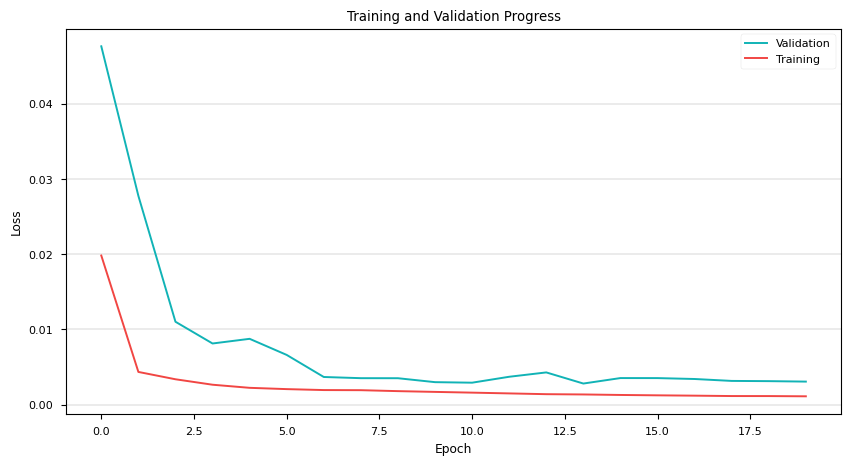

In [43]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load'],
        "features": 'MS'
    },
    "train_args": {
        "model_name": FEDformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 2, 
        'dec_in': 2,
        'seq_len': 6,
        'pred_len': 3,
        'label_len': 3,
        'moving_avg': 3,
        'd_model': 128,
        'n_heads': 8,
        'd_ff': None,
        'dropout': 0.1,
        'e_layers': 1,
        'd_layers': 1,
        'c_out': 128
    },
}
model = train(**params3)

# 基于FiLM的时间序列预测

## 多变量多步预测

### 数据准备

In [44]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [45]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [46]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [47]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [48]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [49]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型定义

In [60]:
def transition(N):
    Q = np.arange(N, dtype=np.float64)
    R = (2 * Q + 1)[:, None]  # / theta
    j, i = np.meshgrid(Q, Q)
    A = np.where(i < j, -1, (-1.) ** (i - j + 1)) * R
    B = (-1.) ** Q[:, None] * R
    return A, B


class HiPPO_LegT(nn.Module):
    def __init__(self, N, dt=1.0, discretization='bilinear'):
        """
        N: the order of the HiPPO projection
        dt: discretization step size - should be roughly inverse to the length of the sequence
        """
        super(HiPPO_LegT, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.N = N
        A, B = transition(N)
        C = np.ones((1, N))
        D = np.zeros((1,))
        A, B, _, _, _ = signal.cont2discrete((A, B, C, D), dt=dt, method=discretization)

        B = B.squeeze(-1)

        self.register_buffer('A', torch.Tensor(A).to(self.device))
        self.register_buffer('B', torch.Tensor(B).to(self.device))
        vals = np.arange(0.0, 1.0, dt)
        self.register_buffer('eval_matrix', torch.Tensor(eval_legendre(np.arange(N)[:, None], 1 - 2 * vals).T).to(self.device))

    def forward(self, inputs):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """
        c = torch.zeros(inputs.shape[:-1] + tuple([self.N])).to(self.device)
        cs = []
        for f in inputs.permute([-1, 0, 1]):
            f = f.unsqueeze(-1)
            new = f @ self.B.unsqueeze(0)
            c = F.linear(c, self.A) + new
            cs.append(c)
        return torch.stack(cs, dim=0)

    def reconstruct(self, c):
        return (self.eval_matrix @ c.unsqueeze(-1)).squeeze(-1)


class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, seq_len, ratio=0.5):
        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.ratio = ratio
        self.modes = min(32, seq_len // 2)
        self.index = list(range(0, self.modes))

        self.scale = (1 / (in_channels * out_channels))
        self.weights_real = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, len(self.index), dtype=torch.float))
        self.weights_imag = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, len(self.index), dtype=torch.float))

    def compl_mul1d(self, order, x, weights_real, weights_imag):
        return torch.complex(torch.einsum(order, x.real, weights_real) - torch.einsum(order, x.imag, weights_imag),
                                 torch.einsum(order, x.real, weights_imag) + torch.einsum(order, x.imag, weights_real))

    def forward(self, x):
        B, H, E, N = x.shape
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(B, H, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        a = x_ft[:, :, :, :self.modes]
        out_ft[:, :, :, :self.modes] = self.compl_mul1d("bjix,iox->bjox", a, self.weights_real, self.weights_imag)
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

# FiLM模型
class FiLM(nn.Module):
    def __init__(self, seq_len, label_len, pred_len, enc_in):
        super(FiLM, self).__init__()
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = seq_len if pred_len == 0 else pred_len

        self.seq_len_all = self.seq_len + self.label_len

        # b, s, f means b, f
        self.affine_weight = nn.Parameter(torch.ones(1, 1, enc_in))
        self.affine_bias = nn.Parameter(torch.zeros(1, 1, enc_in))

        self.multiscale = [1, 2, 4]
        self.window_size = [256]
        ratio = 0.5
        self.legts = nn.ModuleList(
            [HiPPO_LegT(N=n, dt=1. / self.pred_len / i) for n in self.window_size for i in self.multiscale])
        self.spec_conv_1 = nn.ModuleList([SpectralConv1d(in_channels=n, out_channels=n,
                                                         seq_len=min(self.pred_len, self.seq_len),
                                                         ratio=ratio) for n in
                                          self.window_size for _ in range(len(self.multiscale))])
        self.mlp = nn.Linear(len(self.multiscale) * len(self.window_size), 1)

    def forward(self, x_enc):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5).detach()
        x_enc /= stdev

        x_enc = x_enc * self.affine_weight + self.affine_bias
        x_decs = []
        jump_dist = 0
        for i in range(0, len(self.multiscale) * len(self.window_size)):
            x_in_len = self.multiscale[i % len(self.multiscale)] * self.pred_len
            x_in = x_enc[:, -x_in_len:]
            legt = self.legts[i]
            x_in_c = legt(x_in.transpose(1, 2)).permute([1, 2, 3, 0])[:, :, :, jump_dist:]
            out1 = self.spec_conv_1[i](x_in_c)
            if self.seq_len >= self.pred_len:
                x_dec_c = out1.transpose(2, 3)[:, :, self.pred_len - 1 - jump_dist, :]
            else:
                x_dec_c = out1.transpose(2, 3)[:, :, -1, :]
            x_dec = x_dec_c @ legt.eval_matrix[-self.pred_len:, :].T
            x_decs.append(x_dec)
        x_dec = torch.stack(x_decs, dim=-1)
        x_dec = self.mlp(x_dec).squeeze(-1).permute(0, 2, 1)

        # De-Normalization from Non-stationary Transformer
        x_dec = x_dec - self.affine_bias
        x_dec = x_dec / (self.affine_weight + 1e-10)
        x_dec = x_dec * stdev
        dec_out = x_dec + means
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [61]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

In [62]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load'],
        "features": 'MS'
    },
    "train_args": {
        "model_name": FiLM,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 2, 
        'seq_len': 6,
        'pred_len': 3,
        'label_len': 3,
    },
}
model = train(**params3)

  5%|████                                                                              | 1/20 [02:21<44:57, 141.96s/it]

Epoch [1/20], Training Loss: 0.0098, Validation Loss: 0.0121
Validation loss decreased (inf --> 0.012093).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▏                                                                         | 2/20 [04:46<43:02, 143.47s/it]

Epoch [2/20], Training Loss: 0.0054, Validation Loss: 0.0099
Validation loss decreased (0.012093 --> 0.009889).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▎                                                                     | 3/20 [07:17<41:37, 146.93s/it]

Epoch [3/20], Training Loss: 0.0049, Validation Loss: 0.0093
Validation loss decreased (0.009889 --> 0.009323).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▍                                                                 | 4/20 [09:44<39:10, 146.92s/it]

Epoch [4/20], Training Loss: 0.0047, Validation Loss: 0.0092
Validation loss decreased (0.009323 --> 0.009176).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▌                                                             | 5/20 [12:10<36:36, 146.46s/it]

Epoch [5/20], Training Loss: 0.0047, Validation Loss: 0.0091
Validation loss decreased (0.009176 --> 0.009058).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▌                                                         | 6/20 [14:33<33:56, 145.47s/it]

Epoch [6/20], Training Loss: 0.0047, Validation Loss: 0.0091
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0007938926261462366


 35%|████████████████████████████▋                                                     | 7/20 [16:58<31:30, 145.41s/it]

Epoch [7/20], Training Loss: 0.0047, Validation Loss: 0.0091
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.0007269952498697733


 40%|████████████████████████████████▊                                                 | 8/20 [19:21<28:53, 144.42s/it]

Epoch [8/20], Training Loss: 0.0047, Validation Loss: 0.0091
Validation loss decreased (0.009058 --> 0.009054).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|████████████████████████████████████▉                                             | 9/20 [21:45<26:26, 144.26s/it]

Epoch [9/20], Training Loss: 0.0046, Validation Loss: 0.0090
Validation loss decreased (0.009054 --> 0.009011).  Saving model ...
Updating learning rate to 0.0005782172325201155


 50%|████████████████████████████████████████▌                                        | 10/20 [24:10<24:07, 144.72s/it]

Epoch [10/20], Training Loss: 0.0046, Validation Loss: 0.0090
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0005


 55%|████████████████████████████████████████████▌                                    | 11/20 [26:35<21:42, 144.74s/it]

Epoch [11/20], Training Loss: 0.0046, Validation Loss: 0.0090
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.0004217827674798845


 60%|████████████████████████████████████████████████▌                                | 12/20 [29:05<19:31, 146.39s/it]

Epoch [12/20], Training Loss: 0.0046, Validation Loss: 0.0091
EarlyStopping counter: 3 out of 7
Updating learning rate to 0.00034549150281252633


 65%|████████████████████████████████████████████████████▋                            | 13/20 [31:25<16:51, 144.49s/it]

Epoch [13/20], Training Loss: 0.0046, Validation Loss: 0.0091
EarlyStopping counter: 4 out of 7
Updating learning rate to 0.00027300475013022663


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [33:51<14:29, 144.90s/it]

Epoch [14/20], Training Loss: 0.0046, Validation Loss: 0.0090
Validation loss decreased (0.009011 --> 0.009010).  Saving model ...
Updating learning rate to 0.00020610737385376348


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [34:33<14:48, 148.09s/it]


KeyboardInterrupt: 

# 基于Koopa的时间序列预测

## 多变量多步预测

### 数据准备

In [2]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [3]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [4]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [5]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [6]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [7]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型定义

In [8]:
class FourierFilter(nn.Module):
    """
    Fourier Filter: to time-variant and time-invariant term
    """
    def __init__(self, mask_spectrum):
        super(FourierFilter, self).__init__()
        self.mask_spectrum = mask_spectrum
        
    def forward(self, x):
        xf = torch.fft.rfft(x, dim=1)
        mask = torch.ones_like(xf)
        mask[:, self.mask_spectrum, :] = 0
        x_var = torch.fft.irfft(xf*mask, dim=1)
        x_inv = x - x_var
        
        return x_var, x_inv
    

class MLP(nn.Module):
    '''
    Multilayer perceptron to encode/decode high dimension representation of sequential data
    '''
    def __init__(self, 
                 f_in, 
                 f_out, 
                 hidden_dim=128, 
                 hidden_layers=2, 
                 dropout=0.05,
                 activation='tanh'): 
        super(MLP, self).__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise NotImplementedError
        
        layers = [nn.Linear(self.f_in, self.hidden_dim), 
                  self.activation, nn.Dropout(self.dropout)]
        for i in range(self.hidden_layers-2):
            layers += [nn.Linear(self.hidden_dim, self.hidden_dim),
                       self.activation, nn.Dropout(dropout)]
        
        layers += [nn.Linear(hidden_dim, f_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # x:     B x S x f_in
        # y:     B x S x f_out
        y = self.layers(x)
        return y
    

class KPLayer(nn.Module):
    """
    Find koopman transition of linear system by DMD with one step approximation
    """
    def __init__(self): 
        super(KPLayer, self).__init__()
        
        self.K = None # B E E

    def one_step_forward(self, z, return_rec=False, return_K=False):
        B, input_len, E = z.shape
        assert input_len > 1, 'snapshots number should be larger than 1'
        x, y = z[:, :-1], z[:, 1:]

        # solve linear system
        self.K = torch.linalg.lstsq(x, y).solution # B E E
        if torch.isnan(self.K).any():
            print('Encounter K with nan, replace K by identity matrix')
            self.K = torch.eye(self.K.shape[1]).to(self.K.device).unsqueeze(0).repeat(B, 1, 1)

        z_pred = torch.bmm(z[:, -1:], self.K)
        if return_rec:
            z_rec = torch.cat((z[:, :1], torch.bmm(x, self.K)), dim=1)
            return z_rec, z_pred

        return z_pred
    
    def forward(self, z, pred_len=1):
        z_rec, z_pred= self.one_step_forward(z, return_rec=True)
        z_preds = []
        for i in range(pred_len):
            z_pred = torch.bmm(z_pred, self.K)
            z_preds.append(z_pred)
        z_preds = torch.cat(z_preds, dim=1)
        return z_rec, z_preds


class KPLayerApprox(nn.Module):
    """
    Find koopman transition of linear system by DMD with multistep K approximation
    """
    def __init__(self): 
        super(KPLayerApprox, self).__init__()
        
        self.K = None # B E E
        self.K_step = None # B E E

    def forward(self, z, pred_len=1):
        # z:       B L E, koopman invariance space representation
        # z_rec:   B L E, reconstructed representation
        # z_pred:  B S E, forecasting representation
        B, input_len, E = z.shape
        assert input_len > 1, 'snapshots number should be larger than 1'
        x, y = z[:, :-1], z[:, 1:]

        # solve linear system
        self.K = torch.linalg.lstsq(x, y).solution # B E E

        if torch.isnan(self.K).any():
            print('Encounter K with nan, replace K by identity matrix')
            self.K = torch.eye(self.K.shape[1]).to(self.K.device).unsqueeze(0).repeat(B, 1, 1)

        z_rec = torch.cat((z[:, :1], torch.bmm(x, self.K)), dim=1) # B L E
        
        if pred_len <= input_len:
            self.K_step = torch.linalg.matrix_power(self.K, pred_len)
            if torch.isnan(self.K_step).any():
                print('Encounter multistep K with nan, replace it by identity matrix')
                self.K_step = torch.eye(self.K_step.shape[1]).to(self.K_step.device).unsqueeze(0).repeat(B, 1, 1)
            z_pred = torch.bmm(z[:, -pred_len:, :], self.K_step)
        else:
            self.K_step = torch.linalg.matrix_power(self.K, input_len)
            if torch.isnan(self.K_step).any():
                print('Encounter multistep K with nan, replace it by identity matrix')
                self.K_step = torch.eye(self.K_step.shape[1]).to(self.K_step.device).unsqueeze(0).repeat(B, 1, 1)
            temp_z_pred, all_pred = z, []
            for _ in range(math.ceil(pred_len / input_len)):
                temp_z_pred = torch.bmm(temp_z_pred, self.K_step)
                all_pred.append(temp_z_pred)
            z_pred = torch.cat(all_pred, dim=1)[:, :pred_len, :]

        return z_rec, z_pred
    

class TimeVarKP(nn.Module):
    """
    Koopman Predictor with DMD (analysitical solution of Koopman operator)
    Utilize local variations within individual sliding window to predict the future of time-variant term
    """
    def __init__(self,
                 enc_in=8,
                 input_len=96,
                 pred_len=96,
                 seg_len=24,
                 dynamic_dim=128,
                 encoder=None,
                 decoder=None,
                 multistep=False,
                ):
        super(TimeVarKP, self).__init__()
        self.input_len = input_len
        self.pred_len = pred_len
        self.enc_in = enc_in
        self.seg_len = seg_len
        self.dynamic_dim = dynamic_dim
        self.multistep = multistep
        self.encoder, self.decoder = encoder, decoder            
        self.freq = math.ceil(self.input_len / self.seg_len)  # segment number of input
        self.step = math.ceil(self.pred_len / self.seg_len)   # segment number of output
        self.padding_len = self.seg_len * self.freq - self.input_len
        # Approximate mulitstep K by KPLayerApprox when pred_len is large
        self.dynamics = KPLayerApprox() if self.multistep else KPLayer() 

    def forward(self, x):
        # x: B L C
        B, L, C = x.shape

        res = torch.cat((x[:, L-self.padding_len:, :], x) ,dim=1)

        res = res.chunk(self.freq, dim=1)     # F x B P C, P means seg_len
        res = torch.stack(res, dim=1).reshape(B, self.freq, -1)   # B F PC

        res = self.encoder(res) # B F H
        x_rec, x_pred = self.dynamics(res, self.step) # B F H, B S H

        x_rec = self.decoder(x_rec) # B F PC
        x_rec = x_rec.reshape(B, self.freq, self.seg_len, self.enc_in)
        x_rec = x_rec.reshape(B, -1, self.enc_in)[:, :self.input_len, :]  # B L C
        
        x_pred = self.decoder(x_pred)     # B S PC
        x_pred = x_pred.reshape(B, self.step, self.seg_len, self.enc_in)
        x_pred = x_pred.reshape(B, -1, self.enc_in)[:, :self.pred_len, :] # B S C

        return x_rec, x_pred


class TimeInvKP(nn.Module):
    """
    Koopman Predictor with learnable Koopman operator
    Utilize lookback and forecast window snapshots to predict the future of time-invariant term
    """
    def __init__(self,
                 input_len=96,
                 pred_len=96,
                 dynamic_dim=128,
                 encoder=None,
                 decoder=None):
        super(TimeInvKP, self).__init__()
        self.dynamic_dim = dynamic_dim
        self.input_len = input_len
        self.pred_len = pred_len
        self.encoder = encoder
        self.decoder = decoder

        K_init = torch.randn(self.dynamic_dim, self.dynamic_dim)
        U, _, V = torch.svd(K_init) # stable initialization
        self.K = nn.Linear(self.dynamic_dim, self.dynamic_dim, bias=False)
        self.K.weight.data = torch.mm(U, V.t())
    
    def forward(self, x):
        # x: B L C
        res = x.transpose(1, 2) # B C L
        res = self.encoder(res) # B C H
        res = self.K(res) # B C H
        res = self.decoder(res) # B C S
        res = res.transpose(1, 2) # B S C

        return res


# Koopa模型
class Koopa(nn.Module):
    def __init__(self, enc_in, seq_len, pred_len, train_loader, dynamic_dim=128, hidden_dim=64, 
                 hidden_layers=2, num_blocks=3, multistep=False):
        """
        mask_spectrum: list, shared frequency spectrums
        seg_len: int, segment length of time series
        dynamic_dim: int, latent dimension of koopman embedding
        hidden_dim: int, hidden dimension of en/decoder
        hidden_layers: int, number of hidden layers of en/decoder
        num_blocks: int, number of Koopa blocks
        multistep: bool, whether to use approximation for multistep K
        alpha: float, spectrum filter ratio
        """
        super(Koopa, self).__init__()
        self.enc_in = enc_in
        self.input_len = seq_len
        self.pred_len = pred_len

        self.seg_len = self.pred_len
        self.num_blocks = num_blocks
        self.dynamic_dim = dynamic_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.multistep = multistep
        self.alpha = 0.2
        self.mask_spectrum = self._get_mask_spectrum(train_loader)

        self.disentanglement = FourierFilter(self.mask_spectrum)

        # shared encoder/decoder to make koopman embedding consistent
        self.time_inv_encoder = MLP(f_in=self.input_len, f_out=self.dynamic_dim, activation='relu',
                    hidden_dim=self.hidden_dim, hidden_layers=self.hidden_layers)
        self.time_inv_decoder = MLP(f_in=self.dynamic_dim, f_out=self.pred_len, activation='relu',
                           hidden_dim=self.hidden_dim, hidden_layers=self.hidden_layers)
        self.time_inv_kps = self.time_var_kps = nn.ModuleList([
                                TimeInvKP(input_len=self.input_len,
                                    pred_len=self.pred_len, 
                                    dynamic_dim=self.dynamic_dim,
                                    encoder=self.time_inv_encoder, 
                                    decoder=self.time_inv_decoder)
                                for _ in range(self.num_blocks)])

        # shared encoder/decoder to make koopman embedding consistent
        self.time_var_encoder = MLP(f_in=self.seg_len*self.enc_in, f_out=self.dynamic_dim, activation='tanh',
                           hidden_dim=self.hidden_dim, hidden_layers=self.hidden_layers)
        self.time_var_decoder = MLP(f_in=self.dynamic_dim, f_out=self.seg_len*self.enc_in, activation='tanh',
                           hidden_dim=self.hidden_dim, hidden_layers=self.hidden_layers)
        self.time_var_kps = nn.ModuleList([
                    TimeVarKP(enc_in=configs.enc_in,
                        input_len=self.input_len,
                        pred_len=self.pred_len,
                        seg_len=self.seg_len,
                        dynamic_dim=self.dynamic_dim,
                        encoder=self.time_var_encoder,
                        decoder=self.time_var_decoder,
                        multistep=self.multistep)
                    for _ in range(self.num_blocks)])

    def _get_mask_spectrum(self, train_loader):
        """
        get shared frequency spectrums
        """
#         train_data, train_loader = data_provider(configs, 'train')
        amps = 0.0
        for data in train_loader:
            lookback_window = data[0]
            amps += abs(torch.fft.rfft(lookback_window, dim=1)).mean(dim=0).mean(dim=1)
        mask_spectrum = amps.topk(int(amps.shape[0]*self.alpha)).indices
        return mask_spectrum # as the spectrums of time-invariant component
    
    def forward(self, x_enc):
        # Series Stationarization adopted from NSformer
        mean_enc = x_enc.mean(1, keepdim=True).detach() # B x 1 x E
        x_enc = x_enc - mean_enc
        std_enc = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5).detach()
        x_enc = x_enc / std_enc

        # Koopman Forecasting
        residual, forecast = x_enc, None
        for i in range(self.num_blocks):
            time_var_input, time_inv_input = self.disentanglement(residual)
            time_inv_output = self.time_inv_kps[i](time_inv_input)
            time_var_backcast, time_var_output = self.time_var_kps[i](time_var_input)
            residual = residual - time_var_backcast
            if forecast is None:
                forecast = (time_inv_output + time_var_output)
            else:
                forecast += (time_inv_output + time_var_output)

        # Series Stationarization adopted from NSformer
        dec_out = forecast * std_enc + mean_enc

        output = dec_out[:, -self.pred_len:, :] # [B, L, D]
        return output        

### 模型训练

In [9]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

In [10]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load'],
        "features": 'MS'
    },
    "train_args": {
        "model_name": Koopa,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 2, 
        'seq_len': 6,
        'pred_len': 3,
        'train_loader': train_loader,
    },
}
model = train(**params3)

RuntimeError: svd: LAPACK library not found in compilation

# 基于LightTS的时间序列预测

## 多变量多步预测

### 数据准备

In [11]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [12]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [13]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [14]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [15]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [16]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型定义

In [17]:
class IEBlock(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, num_node):
        super(IEBlock, self).__init__()

        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.num_node = num_node

        self._build()

    def _build(self):
        self.spatial_proj = nn.Sequential(
            nn.Linear(self.input_dim, self.hid_dim),
            nn.LeakyReLU(),
            nn.Linear(self.hid_dim, self.hid_dim // 4)
        )

        self.channel_proj = nn.Linear(self.num_node, self.num_node)
        torch.nn.init.eye_(self.channel_proj.weight)

        self.output_proj = nn.Linear(self.hid_dim // 4, self.output_dim)

    def forward(self, x):
        x = self.spatial_proj(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1) + self.channel_proj(x.permute(0, 2, 1))
        x = self.output_proj(x.permute(0, 2, 1))

        x = x.permute(0, 2, 1)

        return x


# LightTS模型
class LightTS(nn.Module):
    def __init__(self, seq_len, pred_len, chunk_size, d_model, enc_in, dropout):
        """
        chunk_size: int, reshape T into [num_chunks, chunk_size]
        """
        super(LightTS, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        self.chunk_size = min(pred_len, seq_len, chunk_size)
        assert (self.seq_len % self.chunk_size == 0)
        self.num_chunks = self.seq_len // self.chunk_size

        self.d_model = d_model
        self.enc_in = enc_in
        self.dropout = dropout
        self._build()

    def _build(self):
        self.layer_1 = IEBlock(
            input_dim=self.chunk_size,
            hid_dim=self.d_model // 4,
            output_dim=self.d_model // 4,
            num_node=self.num_chunks
        )

        self.chunk_proj_1 = nn.Linear(self.num_chunks, 1)

        self.layer_2 = IEBlock(
            input_dim=self.chunk_size,
            hid_dim=self.d_model // 4,
            output_dim=self.d_model // 4,
            num_node=self.num_chunks
        )

        self.chunk_proj_2 = nn.Linear(self.num_chunks, 1)

        self.layer_3 = IEBlock(
            input_dim=self.d_model // 2,
            hid_dim=self.d_model // 2,
            output_dim=self.pred_len,
            num_node=self.enc_in
        )

        self.ar = nn.Linear(self.seq_len, self.pred_len)

    def encoder(self, x):
        B, T, N = x.size()

        highway = self.ar(x.permute(0, 2, 1))
        highway = highway.permute(0, 2, 1)

        # continuous sampling
        x1 = x.reshape(B, self.num_chunks, self.chunk_size, N)
        x1 = x1.permute(0, 3, 2, 1)
        x1 = x1.reshape(-1, self.chunk_size, self.num_chunks)
        x1 = self.layer_1(x1)
        x1 = self.chunk_proj_1(x1).squeeze(dim=-1)

        # interval sampling
        x2 = x.reshape(B, self.chunk_size, self.num_chunks, N)
        x2 = x2.permute(0, 3, 1, 2)
        x2 = x2.reshape(-1, self.chunk_size, self.num_chunks)
        x2 = self.layer_2(x2)
        x2 = self.chunk_proj_2(x2).squeeze(dim=-1)

        x3 = torch.cat([x1, x2], dim=-1)

        x3 = x3.reshape(B, N, -1)
        x3 = x3.permute(0, 2, 1)

        out = self.layer_3(x3)

        out = out + highway
        return out

    def forward(self, x_enc):
        dec_out = self.encoder(x_enc)
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [18]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:12<04:06, 12.96s/it]

Epoch [1/20], Training Loss: 0.0065, Validation Loss: 0.0087
Validation loss decreased (inf --> 0.008701).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:27<04:08, 13.81s/it]

Epoch [2/20], Training Loss: 0.0036, Validation Loss: 0.0065
Validation loss decreased (0.008701 --> 0.006549).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [00:41<03:54, 13.79s/it]

Epoch [3/20], Training Loss: 0.0029, Validation Loss: 0.0063
Validation loss decreased (0.006549 --> 0.006340).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [00:54<03:40, 13.79s/it]

Epoch [4/20], Training Loss: 0.0026, Validation Loss: 0.0060
Validation loss decreased (0.006340 --> 0.005990).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [01:09<03:29, 14.00s/it]

Epoch [5/20], Training Loss: 0.0024, Validation Loss: 0.0058
Validation loss decreased (0.005990 --> 0.005816).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [01:24<03:24, 14.57s/it]

Epoch [6/20], Training Loss: 0.0022, Validation Loss: 0.0050
Validation loss decreased (0.005816 --> 0.004968).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [01:41<03:18, 15.23s/it]

Epoch [7/20], Training Loss: 0.0022, Validation Loss: 0.0058
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [01:58<03:07, 15.66s/it]

Epoch [8/20], Training Loss: 0.0020, Validation Loss: 0.0055
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [02:14<02:54, 15.83s/it]

Epoch [9/20], Training Loss: 0.0019, Validation Loss: 0.0043
Validation loss decreased (0.004968 --> 0.004256).  Saving model ...
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [02:29<02:37, 15.77s/it]

Epoch [10/20], Training Loss: 0.0019, Validation Loss: 0.0042
Validation loss decreased (0.004256 --> 0.004223).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [02:46<02:22, 15.89s/it]

Epoch [11/20], Training Loss: 0.0018, Validation Loss: 0.0045
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [03:01<02:06, 15.85s/it]

Epoch [12/20], Training Loss: 0.0017, Validation Loss: 0.0044
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.00034549150281252633


 60%|█████████████████████████████████████████████████▏                                | 12/20 [03:16<02:11, 16.41s/it]

Epoch [13/20], Training Loss: 0.0016, Validation Loss: 0.0047
EarlyStopping counter: 3 out of 3
Early stopping!


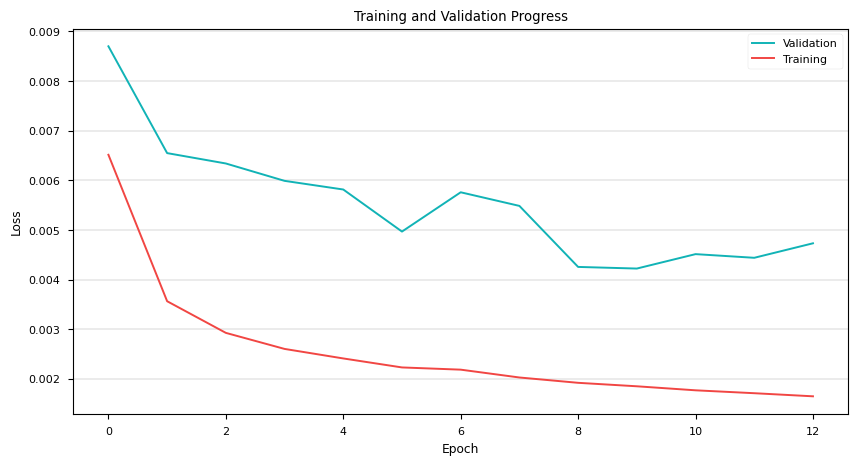

In [21]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load'],
        "features": 'MS'
    },
    "train_args": {
        "model_name": LightTS,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 2, 
        'seq_len': 6,
        'pred_len': 3,
        'd_model': 512,
        'chunk_size': 3,
        'dropout': 0.1
    },
}
model = train(**params3)

# 基于MICN的时间序列预测

## 多变量多步预测

### 数据准备

In [42]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [43]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [44]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [45]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [46]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [47]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


### 模型定义

In [48]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(
                x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# 编码器和解码器
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class series_decomp_multi(nn.Module):
    """
    Multiple Series decomposition block from FEDformer
    """

    def __init__(self, kernel_size):
        super(series_decomp_multi, self).__init__()
        self.kernel_size = kernel_size
        self.series_decomp = [series_decomp(kernel) for kernel in kernel_size]

    def forward(self, x):
        moving_mean = []
        res = []
        for func in self.series_decomp:
            sea, moving_avg = func(x)
            moving_mean.append(moving_avg)
            res.append(sea)

        sea = sum(res) / len(res)
        moving_mean = sum(moving_mean) / len(moving_mean)
        return sea, moving_mean
    
    
class MIC(nn.Module):
    """
    MIC layer to extract local and global features
    """

    def __init__(self, feature_size=512, n_heads=8, dropout=0.05, decomp_kernel=[32], conv_kernel=[24],
                 isometric_kernel=[18, 6]):
        super(MIC, self).__init__()
        self.conv_kernel = conv_kernel
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # isometric convolution
        self.isometric_conv = nn.ModuleList([nn.Conv1d(in_channels=feature_size, out_channels=feature_size,
                                                       kernel_size=i, padding=0, stride=1)
                                             for i in isometric_kernel])

        # downsampling convolution: padding=i//2, stride=i
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=feature_size, out_channels=feature_size,
                                             kernel_size=i, padding=i // 2, stride=i)
                                   for i in conv_kernel])

        # upsampling convolution
        self.conv_trans = nn.ModuleList([nn.ConvTranspose1d(in_channels=feature_size, out_channels=feature_size,
                                                            kernel_size=i, padding=0, stride=i)
                                         for i in conv_kernel])

        self.decomp = nn.ModuleList([series_decomp(k) for k in decomp_kernel])
        self.merge = torch.nn.Conv2d(in_channels=feature_size, out_channels=feature_size,
                                     kernel_size=(len(self.conv_kernel), 1))

        # feedforward network
        self.conv1 = nn.Conv1d(in_channels=feature_size, out_channels=feature_size * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=feature_size * 4, out_channels=feature_size, kernel_size=1)
        self.norm1 = nn.LayerNorm(feature_size)
        self.norm2 = nn.LayerNorm(feature_size)

        self.norm = torch.nn.LayerNorm(feature_size)
        self.act = torch.nn.Tanh()
        self.drop = torch.nn.Dropout(0.05)

    def conv_trans_conv(self, input, conv1d, conv1d_trans, isometric):
        batch, seq_len, channel = input.shape
        x = input.permute(0, 2, 1)

        # downsampling convolution
        x1 = self.drop(self.act(conv1d(x)))
        x = x1

        # isometric convolution
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2] - 1), device=self.device)
        x = torch.cat((zeros, x), dim=-1)
        x = self.drop(self.act(isometric(x)))
        x = self.norm((x + x1).permute(0, 2, 1)).permute(0, 2, 1)

        # upsampling convolution
        x = self.drop(self.act(conv1d_trans(x)))
        x = x[:, :, :seq_len]  # truncate

        x = self.norm(x.permute(0, 2, 1) + input)
        return x

    def forward(self, src):
        # multi-scale
        multi = []
        for i in range(len(self.conv_kernel)):
            src_out, trend1 = self.decomp[i](src)
            src_out = self.conv_trans_conv(src_out, self.conv[i], self.conv_trans[i], self.isometric_conv[i])
            multi.append(src_out)

            # merge
        mg = torch.tensor([], device=self.device)
        for i in range(len(self.conv_kernel)):
            mg = torch.cat((mg, multi[i].unsqueeze(1)), dim=1)
        mg = self.merge(mg.permute(0, 3, 1, 2)).squeeze(-2).permute(0, 2, 1)

        y = self.norm1(mg)
        y = self.conv2(self.conv1(y.transpose(-1, 1))).transpose(-1, 1)

        return self.norm2(mg + y)


class SeasonalPrediction(nn.Module):
    def __init__(self, embedding_size=512, n_heads=8, dropout=0.05, d_layers=1, decomp_kernel=[32], c_out=1,
                 conv_kernel=[2, 4], isometric_kernel=[18, 6]):
        super(SeasonalPrediction, self).__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.mic = nn.ModuleList([MIC(feature_size=embedding_size, n_heads=n_heads,
                                      decomp_kernel=decomp_kernel, conv_kernel=conv_kernel,
                                      isometric_kernel=isometric_kernel)
                                  for i in range(d_layers)])

        self.projection = nn.Linear(embedding_size, c_out)

    def forward(self, dec):
        for mic_layer in self.mic:
            dec = mic_layer(dec)
        return self.projection(dec)


# MICN模型
class MICN(nn.Module):
    def __init__(self, seq_len, pred_len, enc_in, d_model, dropout, n_heads, d_layers, c_out, 
                 conv_kernel=[12, 16]):
        """
        conv_kernel: downsampling and upsampling convolution kernel_size
        """
        super(MICN, self).__init__()

        decomp_kernel = []  # kernel of decomposition operation
        isometric_kernel = []  # kernel of isometric convolution
        for ii in conv_kernel:
            if ii % 2 == 0:  # the kernel of decomposition operation must be odd
                decomp_kernel.append(ii + 1)
                isometric_kernel.append((seq_len + pred_len + ii) // ii)
            else:
                decomp_kernel.append(ii)
                isometric_kernel.append((seq_len + pred_len + ii - 1) // ii)

        self.pred_len = pred_len
        self.seq_len = seq_len

        # Multiple Series decomposition block from FEDformer
        self.decomp_multi = series_decomp_multi(decomp_kernel)

        # embedding
        self.dec_embedding = DataEmbedding(enc_in, d_model, dropout)

        self.conv_trans = SeasonalPrediction(embedding_size=d_model, n_heads=n_heads,
                                             dropout=dropout, d_layers=d_layers, decomp_kernel=decomp_kernel,
                                             c_out=c_out, conv_kernel=conv_kernel,
                                             isometric_kernel=isometric_kernel)
        # refer to DLinear
        self.regression = nn.Linear(seq_len, pred_len)
        self.regression.weight = nn.Parameter((1 / pred_len) * torch.ones([pred_len, seq_len]), requires_grad=True)

    def forward(self, x_enc, x_dec, x_mark_enc=None, x_mark_dec=None):
        # Multi-scale Hybrid Decomposition
        seasonal_init_enc, trend = self.decomp_multi(x_enc)
        trend = self.regression(trend.permute(0, 2, 1)).permute(0, 2, 1)

        # embedding
        zeros = torch.zeros([x_dec.shape[0], self.pred_len, x_dec.shape[2]], device=x_enc.device)
        seasonal_init_dec = torch.cat([seasonal_init_enc[:, -self.seq_len:, :], zeros], dim=1)
        dec_out = self.dec_embedding(seasonal_init_dec, x_mark_dec)
        dec_out = self.conv_trans(dec_out)
        dec_out = dec_out[:, -self.pred_len:, :] + trend[:, -self.pred_len:, :]
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [49]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch, targets_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch, targets_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:32<10:16, 32.43s/it]

Epoch [1/20], Training Loss: 0.0260, Validation Loss: 0.0067
Validation loss decreased (inf --> 0.006736).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [01:05<09:45, 32.53s/it]

Epoch [2/20], Training Loss: 0.0024, Validation Loss: 0.0039
Validation loss decreased (0.006736 --> 0.003865).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [01:38<09:21, 33.06s/it]

Epoch [3/20], Training Loss: 0.0018, Validation Loss: 0.0037
Validation loss decreased (0.003865 --> 0.003698).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [02:12<08:53, 33.34s/it]

Epoch [4/20], Training Loss: 0.0016, Validation Loss: 0.0031
Validation loss decreased (0.003698 --> 0.003123).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [02:45<08:19, 33.30s/it]

Epoch [5/20], Training Loss: 0.0015, Validation Loss: 0.0036
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [03:18<07:44, 33.19s/it]

Epoch [6/20], Training Loss: 0.0014, Validation Loss: 0.0030
Validation loss decreased (0.003123 --> 0.003018).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [03:53<07:16, 33.56s/it]

Epoch [7/20], Training Loss: 0.0013, Validation Loss: 0.0029
Validation loss decreased (0.003018 --> 0.002908).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [04:28<06:49, 34.09s/it]

Epoch [8/20], Training Loss: 0.0012, Validation Loss: 0.0033
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [05:04<06:23, 34.86s/it]

Epoch [9/20], Training Loss: 0.0012, Validation Loss: 0.0038
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [05:41<05:52, 35.29s/it]

Epoch [10/20], Training Loss: 0.0011, Validation Loss: 0.0028
Validation loss decreased (0.002908 --> 0.002841).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [06:17<05:19, 35.55s/it]

Epoch [11/20], Training Loss: 0.0011, Validation Loss: 0.0030
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [06:54<04:48, 36.04s/it]

Epoch [12/20], Training Loss: 0.0010, Validation Loss: 0.0030
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.00034549150281252633


 60%|█████████████████████████████████████████████████▏                                | 12/20 [07:32<05:01, 37.69s/it]

Epoch [13/20], Training Loss: 0.0010, Validation Loss: 0.0031
EarlyStopping counter: 3 out of 3
Early stopping!


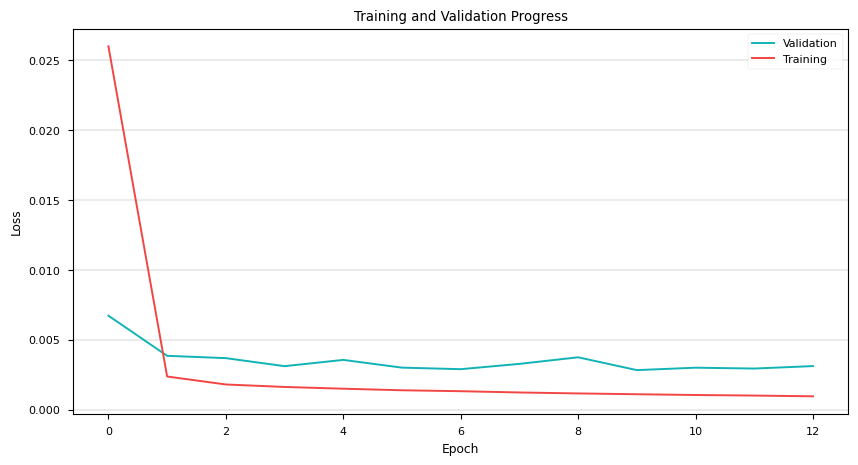

In [50]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": MICN,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 2, 
        'seq_len': 6,
        'pred_len': 3,
        'd_model': 128,
        'n_heads': 8,
        'dropout': 0.1,
        'd_layers': 1,
        'c_out': 2
    },
}
model = train(**params3)

# 基于Nonstationary_Transformer的时间序列预测

非平稳时间序列预测

## 多变量多步预测

### 数据准备

In [52]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [53]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [54]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [55]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [56]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [57]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


### 模型定义

In [65]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
# Transformer_EncDec类
class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x
    
    
# 掩码层
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask    
    
    
# 自注意力层
class DSAttention(nn.Module):
    '''De-stationary Attention'''

    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(DSAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        tau = 1.0 if tau is None else tau.unsqueeze(
            1).unsqueeze(1)  # B x 1 x 1 x 1
        delta = 0.0 if delta is None else delta.unsqueeze(
            1).unsqueeze(1)  # B x 1 x 1 x S

        # De-stationary Attention, rescaling pre-softmax score with learned de-stationary factors
        scores = torch.einsum("blhe,bshe->bhls", queries, keys) * tau + delta

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None
    
    
class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
    
class Projector(nn.Module):
    '''
    MLP to learn the De-stationary factors
    '''

    def __init__(self, enc_in, seq_len, hidden_dims, hidden_layers, output_dim, kernel_size=3):
        super(Projector, self).__init__()

        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.series_conv = nn.Conv1d(in_channels=seq_len, out_channels=1, kernel_size=kernel_size, padding=padding,
                                     padding_mode='circular', bias=False)

        layers = [nn.Linear(2 * enc_in, hidden_dims[0]), nn.ReLU()]
        for i in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_dims[i], hidden_dims[i + 1]), nn.ReLU()]

        layers += [nn.Linear(hidden_dims[-1], output_dim, bias=False)]
        self.backbone = nn.Sequential(*layers)

    def forward(self, x, stats):
        # x:     B x S x E
        # stats: B x 1 x E
        # y:     B x O
        batch_size = x.shape[0]
        x = self.series_conv(x)  # B x 1 x E
        x = torch.cat([x, stats], dim=1)  # B x 2 x E
        x = x.view(batch_size, -1)  # B x 2E
        y = self.backbone(x)  # B x O

        return y


# Nonstationary_Transformer模型
class Nonstationary_Transformer(nn.Module):
    def __init__(self, pred_len, seq_len, label_len, output_attention, enc_in, d_model, 
                 dropout, factor, n_heads, d_ff, e_layers, d_layers, dec_in, c_out, p_hidden_dims, 
                p_hidden_layers):
        super(Nonstationary_Transformer, self).__init__()
        self.pred_len = pred_len
        self.seq_len = seq_len
        self.label_len = label_len
        self.output_attention = output_attention

        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        DSAttention(False, factor, attention_dropout=dropout,
                                    output_attention=output_attention), d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu'
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.dec_embedding = DataEmbedding(dec_in, d_model, dropout)
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        DSAttention(True, factor, attention_dropout=dropout,
                                    output_attention=False),
                        d_model, n_heads),
                    AttentionLayer(
                        DSAttention(False, factor, attention_dropout=dropout,
                                    output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu',
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model),
            projection=nn.Linear(d_model, c_out, bias=True)
        )

        self.tau_learner = Projector(enc_in=enc_in, seq_len=seq_len, hidden_dims=p_hidden_dims,
                                     hidden_layers=p_hidden_layers, output_dim=1)
        self.delta_learner = Projector(enc_in=enc_in, seq_len=seq_len,
                                       hidden_dims=p_hidden_dims, hidden_layers=p_hidden_layers,
                                       output_dim=seq_len)

    def forward(self, x_enc, x_dec, x_mark_enc=None, x_mark_dec=None):
        x_raw = x_enc.clone().detach()

        # Normalization
        mean_enc = x_enc.mean(1, keepdim=True).detach()  # B x 1 x E
        x_enc = x_enc - mean_enc
        std_enc = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5).detach()  # B x 1 x E
        x_enc = x_enc / std_enc
        # B x S x E, B x 1 x E -> B x 1, positive scalar
        tau = self.tau_learner(x_raw, std_enc).exp()
        # B x S x E, B x 1 x E -> B x S
        delta = self.delta_learner(x_raw, mean_enc)

        x_dec_new = torch.cat([x_enc[:, -self.label_len:, :], torch.zeros_like(x_dec[:, -self.pred_len:, :])],
                              dim=1).to(x_enc.device).clone()

        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=None, tau=tau, delta=delta)

        dec_out = self.dec_embedding(x_dec_new, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=None, cross_mask=None, tau=tau, delta=delta)
        dec_out = dec_out * std_enc + mean_enc
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [66]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch, targets_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch, targets_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [01:31<28:50, 91.07s/it]

Epoch [1/20], Training Loss: 0.0025, Validation Loss: 0.0030
Validation loss decreased (inf --> 0.003025).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [03:05<27:57, 93.22s/it]

Epoch [2/20], Training Loss: 0.0016, Validation Loss: 0.0027
Validation loss decreased (0.003025 --> 0.002745).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [04:49<27:43, 97.85s/it]

Epoch [3/20], Training Loss: 0.0012, Validation Loss: 0.0025
Validation loss decreased (0.002745 --> 0.002495).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [06:26<26:01, 97.62s/it]

Epoch [4/20], Training Loss: 0.0011, Validation Loss: 0.0025
Validation loss decreased (0.002495 --> 0.002466).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [08:08<24:50, 99.34s/it]

Epoch [5/20], Training Loss: 0.0010, Validation Loss: 0.0023
Validation loss decreased (0.002466 --> 0.002283).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▌                                                         | 6/20 [09:58<23:58, 102.74s/it]

Epoch [6/20], Training Loss: 0.0010, Validation Loss: 0.0025
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0007938926261462366


 35%|████████████████████████████▋                                                     | 7/20 [11:44<22:29, 103.84s/it]

Epoch [7/20], Training Loss: 0.0009, Validation Loss: 0.0029
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0007269952498697733


 35%|████████████████████████████▋                                                     | 7/20 [13:24<24:53, 114.86s/it]

Epoch [8/20], Training Loss: 0.0009, Validation Loss: 0.0024
EarlyStopping counter: 3 out of 3
Early stopping!


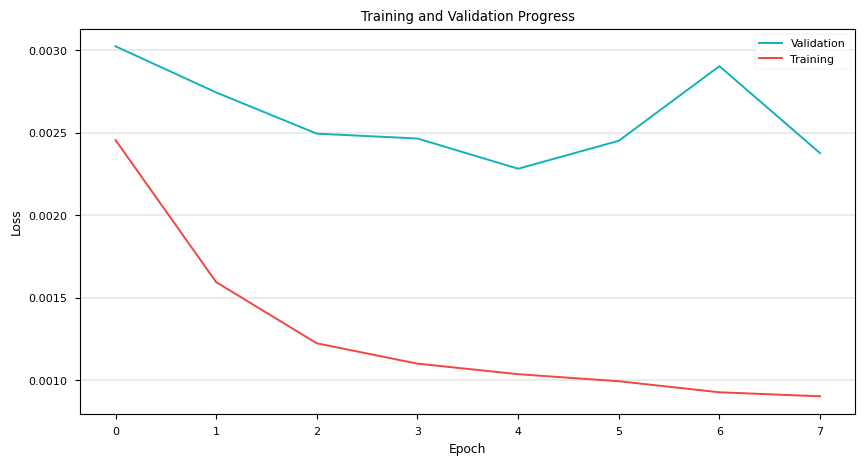

In [67]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": Nonstationary_Transformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'pred_len': 3, 
        'seq_len': 6,
        'label_len': 3,
        'd_model': 128,
        'output_attention': False,
        'enc_in': 2,
        'dec_in': 2,
        'dropout': 0.1,
        'factor': 3, 
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 1,
        'd_layers': 1,
        'p_hidden_dims': [256, 256],
        'p_hidden_layers': 1,
        'c_out': 2,
    },
}
model = train(**params3)

# 基于Pyraformer的时间序列预测

## 多变量多步预测

### 数据准备

In [69]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [70]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [71]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [72]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [73]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [74]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型定义

In [80]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# 自注意力模块
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask
    
    
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None
        
        
class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
    
# Pyraformer_EncDec模块
def get_mask(input_size, window_size, inner_size):
    """Get the attention mask of PAM-Naive"""
    # Get the size of all layers
    all_size = []
    all_size.append(input_size)
    for i in range(len(window_size)):
        layer_size = math.floor(all_size[i] / window_size[i])
        all_size.append(layer_size)

    seq_length = sum(all_size)
    mask = torch.zeros(seq_length, seq_length)

    # get intra-scale mask
    inner_window = inner_size // 2
    for layer_idx in range(len(all_size)):
        start = sum(all_size[:layer_idx])
        for i in range(start, start + all_size[layer_idx]):
            left_side = max(i - inner_window, start)
            right_side = min(i + inner_window + 1, start + all_size[layer_idx])
            mask[i, left_side:right_side] = 1

    # get inter-scale mask
    for layer_idx in range(1, len(all_size)):
        start = sum(all_size[:layer_idx])
        for i in range(start, start + all_size[layer_idx]):
            left_side = (start - all_size[layer_idx - 1]) + \
                (i - start) * window_size[layer_idx - 1]
            if i == (start + all_size[layer_idx] - 1):
                right_side = start
            else:
                right_side = (
                    start - all_size[layer_idx - 1]) + (i - start + 1) * window_size[layer_idx - 1]
            mask[i, left_side:right_side] = 1
            mask[left_side:right_side, i] = 1

    mask = (1 - mask).bool()

    return mask, all_size


def refer_points(all_sizes, window_size):
    """Gather features from PAM's pyramid sequences"""
    input_size = all_sizes[0]
    indexes = torch.zeros(input_size, len(all_sizes))

    for i in range(input_size):
        indexes[i][0] = i
        former_index = i
        for j in range(1, len(all_sizes)):
            start = sum(all_sizes[:j])
            inner_layer_idx = former_index - (start - all_sizes[j - 1])
            former_index = start + \
                min(inner_layer_idx // window_size[j - 1], all_sizes[j] - 1)
            indexes[i][j] = former_index

    indexes = indexes.unsqueeze(0).unsqueeze(3)

    return indexes.long()


class RegularMask():
    def __init__(self, mask):
        self._mask = mask.unsqueeze(1)

    @property
    def mask(self):
        return self._mask


class EncoderLayer(nn.Module):
    """ Compose with two layers """

    def __init__(self, d_model, d_inner, n_head, dropout=0.1, normalize_before=True):
        super(EncoderLayer, self).__init__()

        self.slf_attn = AttentionLayer(
            FullAttention(mask_flag=True, factor=0,
                          attention_dropout=dropout, output_attention=False),
            d_model, n_head)
        self.pos_ffn = PositionwiseFeedForward(
            d_model, d_inner, dropout=dropout, normalize_before=normalize_before)

    def forward(self, enc_input, slf_attn_mask=None):
        attn_mask = RegularMask(slf_attn_mask)
        enc_output, _ = self.slf_attn(
            enc_input, enc_input, enc_input, attn_mask=attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output


class Encoder(nn.Module):
    """ A encoder model with self attention mechanism. """

    def __init__(self, d_model, seq_len, d_ff, n_heads, dropout, e_layers, enc_in, 
                 window_size, inner_size):
        super().__init__()

        d_bottleneck = d_model//4

        self.mask, self.all_size = get_mask(seq_len, window_size, inner_size)
        self.indexes = refer_points(self.all_size, window_size)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, d_ff, n_heads, dropout=dropout,
                         normalize_before=False) for _ in range(e_layers)
        ])  # naive pyramid attention

        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)
        self.conv_layers = Bottleneck_Construct(d_model, window_size, d_bottleneck)

    def forward(self, x_enc, x_mark_enc=None):
        seq_enc = self.enc_embedding(x_enc, x_mark_enc)

        mask = self.mask.repeat(len(seq_enc), 1, 1).to(x_enc.device)
        seq_enc = self.conv_layers(seq_enc)

        for i in range(len(self.layers)):
            seq_enc = self.layers[i](seq_enc, mask)

        indexes = self.indexes.repeat(seq_enc.size(
            0), 1, 1, seq_enc.size(2)).to(seq_enc.device)
        indexes = indexes.view(seq_enc.size(0), -1, seq_enc.size(2))
        all_enc = torch.gather(seq_enc, 1, indexes)
        seq_enc = all_enc.view(seq_enc.size(0), self.all_size[0], -1)

        return seq_enc


class ConvLayer(nn.Module):
    def __init__(self, c_in, window_size):
        super(ConvLayer, self).__init__()
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=window_size,
                                  stride=window_size)
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()

    def forward(self, x):
        x = self.downConv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x


class Bottleneck_Construct(nn.Module):
    """Bottleneck convolution CSCM"""

    def __init__(self, d_model, window_size, d_inner):
        super(Bottleneck_Construct, self).__init__()
        if not isinstance(window_size, list):
            self.conv_layers = nn.ModuleList([
                ConvLayer(d_inner, window_size),
                ConvLayer(d_inner, window_size),
                ConvLayer(d_inner, window_size)
            ])
        else:
            self.conv_layers = []
            for i in range(len(window_size)):
                self.conv_layers.append(ConvLayer(d_inner, window_size[i]))
            self.conv_layers = nn.ModuleList(self.conv_layers)
        self.up = Linear(d_inner, d_model)
        self.down = Linear(d_model, d_inner)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, enc_input):
        temp_input = self.down(enc_input).permute(0, 2, 1)
        all_inputs = []
        for i in range(len(self.conv_layers)):
            temp_input = self.conv_layers[i](temp_input)
            all_inputs.append(temp_input)

        all_inputs = torch.cat(all_inputs, dim=2).transpose(1, 2)
        all_inputs = self.up(all_inputs)
        all_inputs = torch.cat([enc_input, all_inputs], dim=1)

        all_inputs = self.norm(all_inputs)
        return all_inputs


class PositionwiseFeedForward(nn.Module):
    """ Two-layer position-wise feed-forward neural network. """

    def __init__(self, d_in, d_hid, dropout=0.1, normalize_before=True):
        super().__init__()

        self.normalize_before = normalize_before

        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)

        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        if self.normalize_before:
            x = self.layer_norm(x)

        x = F.gelu(self.w_1(x))
        x = self.dropout(x)
        x = self.w_2(x)
        x = self.dropout(x)
        x = x + residual

        if not self.normalize_before:
            x = self.layer_norm(x)
        return x
    
    
# Pyraformer模型
class Pyraformer(nn.Module):
    """ 
    Pyraformer: Pyramidal attention to reduce complexity
    """

    def __init__(self, task_name, pred_len, d_model, seq_len, d_ff, n_heads, dropout, e_layers, enc_in,
                 window_size=[4,4], inner_size=5):
        """
        window_size: list, the downsample window size in pyramidal attention.
        inner_size: int, the size of neighbour attention
        """
        super().__init__()
        self.task_name = task_name
        self.pred_len = pred_len
        self.d_model = d_model

        if self.task_name == 'short_term_forecast':
            window_size = [2,2]
        self.encoder = Encoder(d_model, seq_len, d_ff, n_heads, dropout, e_layers, enc_in, 
                 window_size, inner_size)

        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            self.projection = nn.Linear(
                (len(window_size)+1)*self.d_model, self.pred_len * enc_in)

    def long_forecast(self, x_enc, x_mark_enc):
        enc_out = self.encoder(x_enc, x_mark_enc)[:, -1, :]
        dec_out = self.projection(enc_out).view(
            enc_out.size(0), self.pred_len, -1)
        return dec_out
    
    def short_forecast(self, x_enc, x_mark_enc):
        # Normalization
        mean_enc = x_enc.mean(1, keepdim=True).detach()  # B x 1 x E
        x_enc = x_enc - mean_enc
        std_enc = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5).detach()  # B x 1 x E
        x_enc = x_enc / std_enc

        enc_out = self.encoder(x_enc, x_mark_enc)[:, -1, :]
        dec_out = self.projection(enc_out).view(
            enc_out.size(0), self.pred_len, -1)
        
        dec_out = dec_out * std_enc + mean_enc
        return dec_out

    def forward(self, x_enc, x_mark_enc=None):
        if self.task_name == 'long_term_forecast':
            dec_out = self.long_forecast(x_enc, x_mark_enc)
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        if self.task_name == 'short_term_forecast':
            dec_out = self.short_forecast(x_enc, x_mark_enc)
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        
        return None

### 模型训练

In [81]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [01:00<19:00, 60.01s/it]

Epoch [1/20], Training Loss: 0.0035, Validation Loss: 0.0046
Validation loss decreased (inf --> 0.004638).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [02:03<18:32, 61.80s/it]

Epoch [2/20], Training Loss: 0.0026, Validation Loss: 0.0037
Validation loss decreased (0.004638 --> 0.003724).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [03:00<16:59, 59.98s/it]

Epoch [3/20], Training Loss: 0.0024, Validation Loss: 0.0034
Validation loss decreased (0.003724 --> 0.003406).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [04:01<16:04, 60.29s/it]

Epoch [4/20], Training Loss: 0.0023, Validation Loss: 0.0031
Validation loss decreased (0.003406 --> 0.003099).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [04:59<14:50, 59.35s/it]

Epoch [5/20], Training Loss: 0.0021, Validation Loss: 0.0032
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [05:56<13:41, 58.68s/it]

Epoch [6/20], Training Loss: 0.0021, Validation Loss: 0.0029
Validation loss decreased (0.003099 --> 0.002947).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [06:54<12:38, 58.32s/it]

Epoch [7/20], Training Loss: 0.0019, Validation Loss: 0.0034
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [07:49<11:27, 57.32s/it]

Epoch [8/20], Training Loss: 0.0018, Validation Loss: 0.0039
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [08:47<10:33, 57.60s/it]

Epoch [9/20], Training Loss: 0.0018, Validation Loss: 0.0032
EarlyStopping counter: 3 out of 7
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [09:47<09:42, 58.21s/it]

Epoch [10/20], Training Loss: 0.0018, Validation Loss: 0.0028
Validation loss decreased (0.002947 --> 0.002831).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [10:44<08:40, 57.79s/it]

Epoch [11/20], Training Loss: 0.0017, Validation Loss: 0.0030
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [11:42<07:42, 57.85s/it]

Epoch [12/20], Training Loss: 0.0016, Validation Loss: 0.0027
Validation loss decreased (0.002831 --> 0.002737).  Saving model ...
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [12:36<06:38, 56.96s/it]

Epoch [13/20], Training Loss: 0.0016, Validation Loss: 0.0029
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [13:34<05:43, 57.28s/it]

Epoch [14/20], Training Loss: 0.0015, Validation Loss: 0.0026
Validation loss decreased (0.002737 --> 0.002588).  Saving model ...
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [14:34<04:49, 57.81s/it]

Epoch [15/20], Training Loss: 0.0015, Validation Loss: 0.0025
Validation loss decreased (0.002588 --> 0.002524).  Saving model ...
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [15:31<03:50, 57.70s/it]

Epoch [16/20], Training Loss: 0.0014, Validation Loss: 0.0025
Validation loss decreased (0.002524 --> 0.002475).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [16:27<02:51, 57.15s/it]

Epoch [17/20], Training Loss: 0.0014, Validation Loss: 0.0024
Validation loss decreased (0.002475 --> 0.002380).  Saving model ...
Updating learning rate to 5.449673790581611e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [17:24<01:54, 57.28s/it]

Epoch [18/20], Training Loss: 0.0014, Validation Loss: 0.0025
EarlyStopping counter: 1 out of 7
Updating learning rate to 2.4471741852423235e-05


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [18:22<00:57, 57.21s/it]

Epoch [19/20], Training Loss: 0.0014, Validation Loss: 0.0024
EarlyStopping counter: 2 out of 7
Updating learning rate to 6.15582970243117e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [19:18<00:00, 57.95s/it]

Epoch [20/20], Training Loss: 0.0014, Validation Loss: 0.0024
EarlyStopping counter: 3 out of 7
Updating learning rate to 0.0


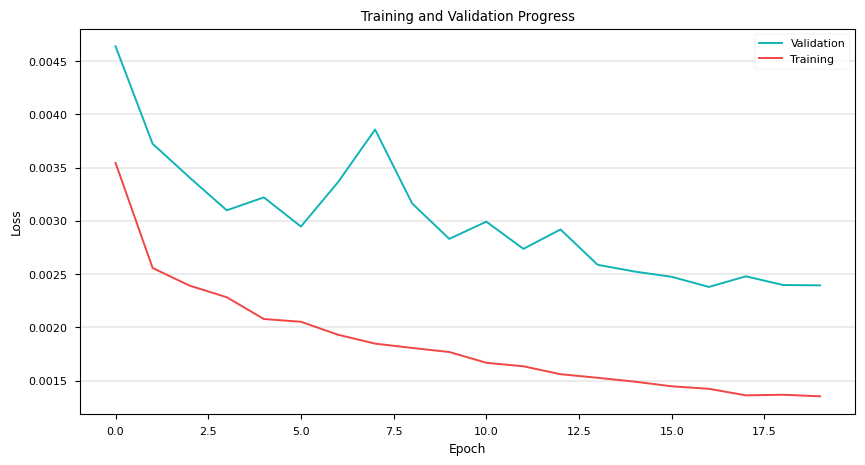

In [82]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load'],
        "features": 'MS'
    },
    "train_args": {
        "model_name": Pyraformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 2, 
        'task_name': 'short_term_forecast',
        'seq_len': 6,
        'pred_len': 3,
        'd_model': 128,
        'n_heads': 8,
        'd_ff': 128,
        'dropout': 0.1,
        'e_layers': 1,
    },
}
model = train(**params3)

# 基于Reformer的时间序列预测

## 多变量多步预测

### 数据准备

In [84]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [85]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [86]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [87]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [88]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [89]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


### 模型定义

In [139]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# Transformer_EncDec类
class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns
    
    
# 自编码类
TOKEN_SELF_ATTN_VALUE = -5e4 # carefully set for half precision to work

def max_neg_value(tensor):
    return -torch.finfo(tensor.dtype).max


def batched_index_select(values, indices):
    last_dim = values.shape[-1]
    return values.gather(1, indices[:, :, None].expand(-1, -1, last_dim))


def sort_key_val(t1, t2, dim=-1):
    values, indices = t1.sort(dim=dim)
    t2 = t2.expand_as(t1)
    return values, t2.gather(dim, indices)


def process_inputs_chunk(fn, chunks=1, dim=0):
    def inner_fn(*args, **kwargs):
        keys, values, len_args = kwargs.keys(), kwargs.values(), len(args)
        chunked_args = list(zip(*map(lambda x: x.chunk(chunks, dim=dim), list(args) + list(values))))
        all_args = map(lambda x: (x[:len_args], dict(zip(keys, x[len_args:]))), chunked_args)
        outputs = [fn(*c_args, **c_kwargs) for c_args, c_kwargs in all_args]
        return tuple(map(lambda x: torch.cat(x, dim=dim), zip(*outputs)))
    return inner_fn


def split_at_index(dim, index, t):
    pre_slices = (slice(None),) * dim
    l = (*pre_slices, slice(None, index))
    r = (*pre_slices, slice(index, None))
    return t[l], t[r]


def merge_dims(ind_from, ind_to, tensor):
    shape = list(tensor.shape)
    arr_slice = slice(ind_from, ind_to + 1)
    shape[arr_slice] = [reduce(mul, shape[arr_slice])]
    return tensor.reshape(*shape)


def exists(val):
    return val is not None


def default(val, default_val):
    return default_val if val is None else val


def cache_method_decorator(cache_attr, cache_namespace, reexecute = False):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, key_namespace=None, fetch=False, set_cache=True, **kwargs):
            namespace_str = str(default(key_namespace, ''))
            _cache = getattr(self, cache_attr)
            _keyname = f'{cache_namespace}:{namespace_str}'

            if fetch:
                val = _cache[_keyname]
                if reexecute:
                    fn(self, *args, **kwargs)
            else:
                val = fn(self, *args, **kwargs)
                if set_cache:
                    setattr(self, cache_attr, {**_cache, **{_keyname: val}})
            return val
        return wrapper
    return inner_fn


class FullQKAttention(nn.Module):
    def __init__(self, causal = False, dropout = 0.):
        super().__init__()
        self.causal = causal
        self.dropout = nn.Dropout(dropout)

    def forward(self, qk, v, query_len = None, input_mask = None, input_attn_mask = None, **kwargs):
        b, seq_len, dim = qk.shape
        query_len = default(query_len, seq_len)
        t = query_len

        q = qk[:, 0:query_len]
        qk = F.normalize(qk, 2, dim=-1).type_as(q)

        dot = torch.einsum('bie,bje->bij', q, qk) * (dim ** -0.5)

        # qk attention requires tokens not attend to self
        i = torch.arange(t)
        dot[:, i, i] = TOKEN_SELF_ATTN_VALUE
        masked_value = max_neg_value(dot)

        # Input mask for padding in variable lengthed sequences
        if input_mask is not None:
            mask = input_mask[:, 0:query_len, None] * input_mask[:, None, :]
            mask = F.pad(mask, (0, seq_len - mask.shape[-1]), value=True)
            dot.masked_fill_(~mask, masked_value)

        # Mask for post qk attention logits of the input sequence
        if input_attn_mask is not None:
            input_attn_mask = F.pad(input_attn_mask, (0, seq_len - input_attn_mask.shape[-1]), value=True)
            dot.masked_fill_(~input_attn_mask, masked_value)

        if self.causal:
            i, j = torch.triu_indices(t, t, 1)
            dot[:, i, j] = masked_value

        dot = dot.softmax(dim=-1)
        dot = self.dropout(dot)

        out = torch.einsum('bij,bje->bie', dot, v)

        return out, dot, torch.empty(0)

    
class LocalAttention(nn.Module):
    def __init__(
        self,
        window_size,
        causal = False,
        look_backward = 1,
        look_forward = None,
        dropout = 0.,
        shared_qk = False,
        rel_pos_emb_config = None,
        dim = None,
        autopad = False,
        exact_windowsize = False,
        scale = None,
        use_rotary_pos_emb = True,
        use_xpos = False,
        xpos_scale_base = None
    ):
        super().__init__()
        look_forward = default(look_forward, 0 if causal else 1)
        assert not (causal and look_forward > 0), 'you cannot look forward if causal'

        self.scale = scale

        self.window_size = window_size
        self.autopad = autopad
        self.exact_windowsize = exact_windowsize

        self.causal = causal

        self.look_backward = look_backward
        self.look_forward = look_forward

        self.dropout = nn.Dropout(dropout)

        self.shared_qk = shared_qk

        # relative positions

        self.rel_pos = None
        self.use_xpos = use_xpos

        if use_rotary_pos_emb and (exists(rel_pos_emb_config) or exists(dim)):  # backwards compatible with old `rel_pos_emb_config` deprecated argument
            if exists(rel_pos_emb_config):
                dim = rel_pos_emb_config[0]

            self.rel_pos = SinusoidalEmbeddings(
                dim,
                use_xpos = use_xpos,
                scale_base = default(xpos_scale_base, window_size // 2)
            )

    def forward(
        self,
        q, k, v,
        mask = None,
        input_mask = None,
        attn_bias = None,
        window_size = None
    ):

        mask = default(mask, input_mask)

        assert not (exists(window_size) and not self.use_xpos), 'cannot perform window size extrapolation if xpos is not turned on'

        shape, autopad, pad_value, window_size, causal, look_backward, look_forward, shared_qk = q.shape, self.autopad, -1, default(window_size, self.window_size), self.causal, self.look_backward, self.look_forward, self.shared_qk

        # https://github.com/arogozhnikov/einops/blob/master/docs/4-pack-and-unpack.ipynb
        (q, packed_shape), (k, _), (v, _) = map(lambda t: pack([t], '* n d'), (q, k, v))

        # auto padding

        if autopad:
            orig_seq_len = q.shape[1]
            (needed_pad, q), (_, k), (_, v) = map(lambda t: pad_to_multiple(t, self.window_size, dim = -2), (q, k, v))

        b, n, dim_head, device, dtype = *q.shape, q.device, q.dtype

        scale = default(self.scale, dim_head ** -0.5)

        assert (n % window_size) == 0, f'sequence length {n} must be divisible by window size {window_size} for local attention'

        windows = n // window_size

        if shared_qk:
            k = l2norm(k)

        seq = torch.arange(n, device = device)
        b_t = rearrange(seq, '(w n) -> 1 w n', w = windows, n = window_size)

        # bucketing

        bq, bk, bv = map(lambda t: rearrange(t, 'b (w n) d -> b w n d', w = windows), (q, k, v))

        bq = bq * scale

        look_around_kwargs = dict(
            backward =  look_backward,
            forward =  look_forward,
            pad_value = pad_value
        )

        bk = look_around(bk, **look_around_kwargs)
        bv = look_around(bv, **look_around_kwargs)

        # rotary embeddings

        if exists(self.rel_pos):
            pos_emb, xpos_scale = self.rel_pos(bk)
            bq, bk = apply_rotary_pos_emb(bq, bk, pos_emb, scale = xpos_scale)

        # calculate positions for masking

        bq_t = b_t
        bq_k = look_around(b_t, **look_around_kwargs)

        bq_t = rearrange(bq_t, '... i -> ... i 1')
        bq_k = rearrange(bq_k, '... j -> ... 1 j')

        pad_mask = bq_k == pad_value

        sim = einsum('b h i e, b h j e -> b h i j', bq, bk)

        if exists(attn_bias):
            heads = attn_bias.shape[0]
            assert (b % heads) == 0

            attn_bias = repeat(attn_bias, 'h i j -> (b h) 1 i j', b = b // heads)
            sim = sim + attn_bias

        mask_value = max_neg_value(sim)

        if shared_qk:
            self_mask = bq_t == bq_k
            sim = sim.masked_fill(self_mask, TOKEN_SELF_ATTN_VALUE)
            del self_mask

        if causal:
            causal_mask = bq_t < bq_k

            if self.exact_windowsize:
                max_causal_window_size = (self.window_size * self.look_backward)
                causal_mask = causal_mask | (bq_t > (bq_k + max_causal_window_size))

            sim = sim.masked_fill(causal_mask, mask_value)
            del causal_mask

        # masking out for exact window size for non-causal
        # as well as masking out for padding value

        if not causal and self.exact_windowsize:
            max_backward_window_size = (self.window_size * self.look_backward)
            max_forward_window_size = (self.window_size * self.look_forward)
            window_mask = ((bq_k - max_forward_window_size) > bq_t) | (bq_t > (bq_k + max_backward_window_size)) | pad_mask
            sim = sim.masked_fill(window_mask, mask_value)
        else:
            sim = sim.masked_fill(pad_mask, mask_value)

        # take care of key padding mask passed in

        if exists(mask):
            batch = mask.shape[0]
            assert (b % batch) == 0

            h = b // mask.shape[0]

            if autopad:
                _, mask = pad_to_multiple(mask, window_size, dim = -1, value = False)

            mask = rearrange(mask, '... (w n) -> (...) w n', w = windows, n = window_size)
            mask = look_around(mask, **{**look_around_kwargs, 'pad_value': False})
            mask = rearrange(mask, '... j -> ... 1 j')
            mask = repeat(mask, 'b ... -> (b h) ...', h = h)
            sim = sim.masked_fill(~mask, mask_value)
            del mask

        # attention

        attn = sim.softmax(dim = -1)
        attn = self.dropout(attn)

        # aggregation

        out = einsum('b h i j, b h j e -> b h i e', attn, bv)
        out = rearrange(out, 'b w n d -> b (w n) d')

        if autopad:
            out = out[:, :orig_seq_len, :]

        out, *_ = unpack(out, packed_shape, '* n d')
        return out


class LSHSelfAttention(nn.Module):
    def __init__(self, dim, heads = 8, bucket_size = 64, n_hashes = 8, causal = False, dim_head = None, attn_chunks = 1, random_rotations_per_head = False, attend_across_buckets = True, allow_duplicate_attention = True, num_mem_kv = 0, one_value_head = False, use_full_attn = False, full_attn_thres = None, return_attn = False, post_attn_dropout = 0., dropout = 0., n_local_attn_heads = 0, **kwargs):
        super().__init__()
        assert dim_head or (dim % heads) == 0, 'dimensions must be divisible by number of heads'
        assert n_local_attn_heads < heads, 'local attention heads must be less than number of heads'

        dim_head = default(dim_head, dim // heads)
        dim_heads = dim_head * heads

        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        self.attn_chunks = default(attn_chunks, 1)

        self.v_head_repeats = (heads if one_value_head else 1)
        v_dim = dim_heads // self.v_head_repeats

        self.toqk = nn.Linear(dim, dim_heads, bias = False)
        self.tov = nn.Linear(dim, v_dim, bias = False)
        self.to_out = nn.Linear(dim_heads, dim)

        self.bucket_size = bucket_size
        self.lsh_attn = LSHAttention(bucket_size=bucket_size, n_hashes=n_hashes, causal=causal, random_rotations_per_head=random_rotations_per_head, attend_across_buckets = attend_across_buckets,  allow_duplicate_attention = allow_duplicate_attention, return_attn = return_attn, dropout = dropout, **kwargs)
        self.full_attn = FullQKAttention(causal=causal, dropout=dropout)
        self.post_attn_dropout = nn.Dropout(post_attn_dropout)

        self.use_full_attn = use_full_attn
        self.full_attn_thres = default(full_attn_thres, bucket_size)

        self.num_mem_kv = num_mem_kv
        self.mem_kv = nn.Parameter(torch.randn(1, num_mem_kv, dim, requires_grad=True)) if num_mem_kv > 0 else None

        self.n_local_attn_heads = n_local_attn_heads
        self.local_attn = LocalAttention(window_size=bucket_size * 2, causal=causal, dropout=dropout, shared_qk=True, look_forward=(1 if not causal else 0))

        self.callback = None

    def forward(self, x, keys = None, input_mask = None, input_attn_mask = None, context_mask = None, pos_emb = None, **kwargs):
        device, dtype = x.device, x.dtype
        b, t, e, h, dh, m, l_h = *x.shape, self.heads, self.dim_head, self.num_mem_kv, self.n_local_attn_heads

        mem_kv = default(self.mem_kv, torch.empty(b, 0, e, dtype=dtype, device=device))
        mem = mem_kv.expand(b, m, -1)

        keys = default(keys, torch.empty(b, 0, e, dtype=dtype, device=device))
        c = keys.shape[1]

        kv_len = t + m + c
        use_full_attn = self.use_full_attn or kv_len <= self.full_attn_thres

        x = torch.cat((x, mem, keys), dim=1)
        qk = self.toqk(x)
        v = self.tov(x)
        v = v.repeat(1, 1, self.v_head_repeats)

        def merge_heads(v):
            return v.view(b, kv_len, h, -1).transpose(1, 2)

        def split_heads(v):
            return v.view(b, h, t, -1).transpose(1, 2).contiguous()

        merge_batch_and_heads = partial(merge_dims, 0, 1)

        qk, v = map(merge_heads, (qk, v))

        has_local = l_h > 0
        lsh_h = h - l_h

        split_index_fn = partial(split_at_index, 1, l_h)
        (lqk, qk), (lv, v) = map(split_index_fn, (qk, v))
        lqk, qk, lv, v = map(merge_batch_and_heads, (lqk, qk, lv, v))

        masks = {}
        if input_mask is not None or context_mask is not None:
            default_mask = torch.tensor([True], device=device)
            i_mask = default(input_mask, default_mask.expand(b, t))
            m_mask = default_mask.expand(b, m)
            c_mask = default(context_mask, default_mask.expand(b, c))
            mask = torch.cat((i_mask, m_mask, c_mask), dim=1)
            mask = merge_batch_and_heads(expand_dim(1, lsh_h, mask))
            masks['input_mask'] = mask

        if input_attn_mask is not None:
            input_attn_mask = merge_batch_and_heads(expand_dim(1, lsh_h, input_attn_mask))
            masks['input_attn_mask'] = input_attn_mask

        attn_fn = self.lsh_attn if not use_full_attn else self.full_attn
        partial_attn_fn = partial(attn_fn, query_len = t, pos_emb = pos_emb, **kwargs)
        attn_fn_in_chunks = process_inputs_chunk(partial_attn_fn, chunks = self.attn_chunks)

        out, attn, buckets = attn_fn_in_chunks(qk, v, **masks)

        if self.callback is not None:
            self.callback(attn.reshape(b, lsh_h, t, -1), buckets.reshape(b, lsh_h, -1))

        if has_local:
            lqk, lv = lqk[:, :t], lv[:, :t]
            local_out = self.local_attn(lqk, lqk, lv, input_mask=input_mask)
            local_out = local_out.reshape(b, l_h, t, -1)
            out = out.reshape(b, lsh_h, t, -1)
            out = torch.cat((local_out, out), dim=1)

        out = split_heads(out).view(b, t, -1)
        out = self.to_out(out)
        return self.post_attn_dropout(out)

    
class LSHSelfAttention(nn.Module):
    def __init__(self, dim, heads = 8, bucket_size = 64, n_hashes = 8, causal = False, dim_head = None, attn_chunks = 1, random_rotations_per_head = False, attend_across_buckets = True, allow_duplicate_attention = True, num_mem_kv = 0, one_value_head = False, use_full_attn = False, full_attn_thres = None, return_attn = False, post_attn_dropout = 0., dropout = 0., n_local_attn_heads = 0, **kwargs):
        super().__init__()
        assert dim_head or (dim % heads) == 0, 'dimensions must be divisible by number of heads'
        assert n_local_attn_heads < heads, 'local attention heads must be less than number of heads'

        dim_head = default(dim_head, dim // heads)
        dim_heads = dim_head * heads

        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        self.attn_chunks = default(attn_chunks, 1)

        self.v_head_repeats = (heads if one_value_head else 1)
        v_dim = dim_heads // self.v_head_repeats

        self.toqk = nn.Linear(dim, dim_heads, bias = False)
        self.tov = nn.Linear(dim, v_dim, bias = False)
        self.to_out = nn.Linear(dim_heads, dim)

        self.bucket_size = bucket_size
        self.lsh_attn = LSHAttention(bucket_size=bucket_size, n_hashes=n_hashes, causal=causal, random_rotations_per_head=random_rotations_per_head, attend_across_buckets = attend_across_buckets,  allow_duplicate_attention = allow_duplicate_attention, return_attn = return_attn, dropout = dropout, **kwargs)
        self.full_attn = FullQKAttention(causal=causal, dropout=dropout)
        self.post_attn_dropout = nn.Dropout(post_attn_dropout)

        self.use_full_attn = use_full_attn
        self.full_attn_thres = default(full_attn_thres, bucket_size)

        self.num_mem_kv = num_mem_kv
        self.mem_kv = nn.Parameter(torch.randn(1, num_mem_kv, dim, requires_grad=True)) if num_mem_kv > 0 else None

        self.n_local_attn_heads = n_local_attn_heads
        self.local_attn = LocalAttention(window_size=bucket_size * 2, causal=causal, dropout=dropout, shared_qk=True, look_forward=(1 if not causal else 0))

        self.callback = None

    def forward(self, x, keys = None, input_mask = None, input_attn_mask = None, context_mask = None, pos_emb = None, **kwargs):
        device, dtype = x.device, x.dtype
        b, t, e, h, dh, m, l_h = *x.shape, self.heads, self.dim_head, self.num_mem_kv, self.n_local_attn_heads

        mem_kv = default(self.mem_kv, torch.empty(b, 0, e, dtype=dtype, device=device))
        mem = mem_kv.expand(b, m, -1)

        keys = default(keys, torch.empty(b, 0, e, dtype=dtype, device=device))
        c = keys.shape[1]

        kv_len = t + m + c
        use_full_attn = self.use_full_attn or kv_len <= self.full_attn_thres

        x = torch.cat((x, mem, keys), dim=1)
        qk = self.toqk(x)
        v = self.tov(x)
        v = v.repeat(1, 1, self.v_head_repeats)

        def merge_heads(v):
            return v.view(b, kv_len, h, -1).transpose(1, 2)

        def split_heads(v):
            return v.view(b, h, t, -1).transpose(1, 2).contiguous()

        merge_batch_and_heads = partial(merge_dims, 0, 1)

        qk, v = map(merge_heads, (qk, v))

        has_local = l_h > 0
        lsh_h = h - l_h

        split_index_fn = partial(split_at_index, 1, l_h)
        (lqk, qk), (lv, v) = map(split_index_fn, (qk, v))
        lqk, qk, lv, v = map(merge_batch_and_heads, (lqk, qk, lv, v))

        masks = {}
        if input_mask is not None or context_mask is not None:
            default_mask = torch.tensor([True], device=device)
            i_mask = default(input_mask, default_mask.expand(b, t))
            m_mask = default_mask.expand(b, m)
            c_mask = default(context_mask, default_mask.expand(b, c))
            mask = torch.cat((i_mask, m_mask, c_mask), dim=1)
            mask = merge_batch_and_heads(expand_dim(1, lsh_h, mask))
            masks['input_mask'] = mask

        if input_attn_mask is not None:
            input_attn_mask = merge_batch_and_heads(expand_dim(1, lsh_h, input_attn_mask))
            masks['input_attn_mask'] = input_attn_mask

        attn_fn = self.lsh_attn if not use_full_attn else self.full_attn
        partial_attn_fn = partial(attn_fn, query_len = t, pos_emb = pos_emb, **kwargs)
        attn_fn_in_chunks = process_inputs_chunk(partial_attn_fn, chunks = self.attn_chunks)

        out, attn, buckets = attn_fn_in_chunks(qk, v, **masks)

        if self.callback is not None:
            self.callback(attn.reshape(b, lsh_h, t, -1), buckets.reshape(b, lsh_h, -1))

        if has_local:
            lqk, lv = lqk[:, :t], lv[:, :t]
            local_out = self.local_attn(lqk, lqk, lv, input_mask=input_mask)
            local_out = local_out.reshape(b, l_h, t, -1)
            out = out.reshape(b, lsh_h, t, -1)
            out = torch.cat((local_out, out), dim=1)

        out = split_heads(out).view(b, t, -1)
        out = self.to_out(out)
        return self.post_attn_dropout(out)


class ReformerLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None, causal=False, bucket_size=4, n_hashes=4):
        super().__init__()
        self.bucket_size = bucket_size
        self.attn = LSHSelfAttention(
            dim=d_model,
            heads=n_heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=causal
        )

    def fit_length(self, queries):
        # inside reformer: assert N % (bucket_size * 2) == 0
        B, N, C = queries.shape
        if N % (self.bucket_size * 2) == 0:
            return queries
        else:
            # fill the time series
            fill_len = (self.bucket_size * 2) - (N % (self.bucket_size * 2))
            return torch.cat([queries, torch.zeros([B, fill_len, C]).to(queries.device)], dim=1)

    def forward(self, queries, keys, values, attn_mask, tau, delta):
        # in Reformer: defalut queries=keys
        B, N, C = queries.shape
        queries = self.attn(self.fit_length(queries))[:, :N, :]
        return queries, None

    
# Reformer模型
class Reformer(nn.Module):
    """
    Reformer with O(LlogL) complexity
    """
    def __init__(self, task_name, pred_len, seq_len, enc_in, d_model, dropout, n_heads, d_ff, 
                 e_layers, c_out, bucket_size=4, n_hashes=4):
        """
        bucket_size: int, 
        n_hashes: int, 
        """
        super(Reformer, self).__init__()
        self.task_name = task_name
        self.pred_len = pred_len
        self.seq_len = seq_len

        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    ReformerLayer(None, d_model, n_heads,
                                  bucket_size=bucket_size, n_hashes=n_hashes),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu'
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        
        self.projection = nn.Linear(d_model, c_out, bias=True)

    def long_forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # add placeholder
        x_enc = torch.cat([x_enc, x_dec[:, -self.pred_len:, :]], dim=1)
        if x_mark_enc is not None:
            x_mark_enc = torch.cat(
                [x_mark_enc, x_mark_dec[:, -self.pred_len:, :]], dim=1)

        enc_out = self.enc_embedding(x_enc, x_mark_enc)  # [B,T,C]
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        dec_out = self.projection(enc_out)

        return dec_out  # [B, L, D]
    
    def short_forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # Normalization
        mean_enc = x_enc.mean(1, keepdim=True).detach()  # B x 1 x E
        x_enc = x_enc - mean_enc
        std_enc = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5).detach()  # B x 1 x E
        x_enc = x_enc / std_enc

        # add placeholder
        x_enc = torch.cat([x_enc, x_dec[:, -self.pred_len:, :]], dim=1)
        if x_mark_enc is not None:
            x_mark_enc = torch.cat(
                [x_mark_enc, x_mark_dec[:, -self.pred_len:, :]], dim=1)

        enc_out = self.enc_embedding(x_enc, x_mark_enc)  # [B,T,C]
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        dec_out = self.projection(enc_out)

        dec_out = dec_out * std_enc + mean_enc
        return dec_out  # [B, L, D]

    def forward(self, x_enc, x_dec, x_mark_enc=None, x_mark_dec=None, mask=None):
        if self.task_name == 'long_term_forecast':
            dec_out = self.long_forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        if self.task_name == 'short_term_forecast':
            dec_out = self.short_forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        
        return None

### 模型训练

In [140]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch, targets_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch, targets_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

In [141]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": Reformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'task_name': 'short_term_forecast',
        'pred_len': 3, 
        'seq_len': 6,
        'd_model': 128,
        'enc_in': 2,
        'dropout': 0.1,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 1,
        'c_out': 2
    },
}
model = train(**params3)

  5%|████                                                                              | 1/20 [02:12<41:51, 132.16s/it]

Epoch [1/20], Training Loss: 0.0033, Validation Loss: 0.0039
Validation loss decreased (inf --> 0.003921).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▏                                                                         | 2/20 [04:35<41:35, 138.65s/it]

Epoch [2/20], Training Loss: 0.0019, Validation Loss: 0.0036
Validation loss decreased (0.003921 --> 0.003631).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▎                                                                     | 3/20 [07:01<40:17, 142.18s/it]

Epoch [3/20], Training Loss: 0.0017, Validation Loss: 0.0030
Validation loss decreased (0.003631 --> 0.003043).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▍                                                                 | 4/20 [09:30<38:38, 144.88s/it]

Epoch [4/20], Training Loss: 0.0015, Validation Loss: 0.0029
Validation loss decreased (0.003043 --> 0.002912).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▌                                                             | 5/20 [11:59<36:33, 146.25s/it]

Epoch [5/20], Training Loss: 0.0014, Validation Loss: 0.0027
Validation loss decreased (0.002912 --> 0.002697).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▌                                                         | 6/20 [14:26<34:13, 146.68s/it]

Epoch [6/20], Training Loss: 0.0013, Validation Loss: 0.0026
Validation loss decreased (0.002697 --> 0.002555).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|████████████████████████████▋                                                     | 7/20 [16:55<31:52, 147.15s/it]

Epoch [7/20], Training Loss: 0.0012, Validation Loss: 0.0024
Validation loss decreased (0.002555 --> 0.002448).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|████████████████████████████████▊                                                 | 8/20 [19:29<29:51, 149.31s/it]

Epoch [8/20], Training Loss: 0.0012, Validation Loss: 0.0023
Validation loss decreased (0.002448 --> 0.002289).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|████████████████████████████████████▉                                             | 9/20 [22:03<27:39, 150.88s/it]

Epoch [9/20], Training Loss: 0.0011, Validation Loss: 0.0024
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0005782172325201155


 50%|████████████████████████████████████████▌                                        | 10/20 [24:35<25:12, 151.20s/it]

Epoch [10/20], Training Loss: 0.0011, Validation Loss: 0.0022
Validation loss decreased (0.002289 --> 0.002211).  Saving model ...
Updating learning rate to 0.0005


 55%|████████████████████████████████████████████▌                                    | 11/20 [27:05<22:37, 150.79s/it]

Epoch [11/20], Training Loss: 0.0010, Validation Loss: 0.0023
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0004217827674798845


 60%|████████████████████████████████████████████████▌                                | 12/20 [29:34<20:03, 150.46s/it]

Epoch [12/20], Training Loss: 0.0010, Validation Loss: 0.0023
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.00034549150281252633


 65%|████████████████████████████████████████████████████▋                            | 13/20 [32:04<17:30, 150.11s/it]

Epoch [13/20], Training Loss: 0.0010, Validation Loss: 0.0021
Validation loss decreased (0.002211 --> 0.002085).  Saving model ...
Updating learning rate to 0.00027300475013022663


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [34:33<14:59, 149.91s/it]

Epoch [14/20], Training Loss: 0.0009, Validation Loss: 0.0021
Validation loss decreased (0.002085 --> 0.002058).  Saving model ...
Updating learning rate to 0.00020610737385376348


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [35:25<15:10, 151.79s/it]


KeyboardInterrupt: 

# 基于TiDE的时间序列预测

## 多变量多步预测

### 数据准备

In [170]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [171]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [172]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [173]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [174]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [175]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


### 模型定义

In [182]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias,
                            1e-5)


class ResBlock(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 output_dim,
                 dropout=0.1,
                 bias=True):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=bias)
        self.fc3 = nn.Linear(input_dim, output_dim, bias=bias)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.ln = LayerNorm(output_dim, bias=bias)

    def forward(self, x):

        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = out + self.fc3(x)
        out = self.ln(out)
        return out


# TiDE模型
class TiDE(nn.Module):
    def __init__(self, seq_len, pred_len, d_model, e_layers, d_layers, freq, d_ff, dropout, c_out, 
                 bias=True, feature_encode_dim=2):
        super(TiDE, self).__init__()
        self.seq_len = seq_len  #L
        self.pred_len = pred_len  #H
        self.hidden_dim = d_model
        self.res_hidden = d_model
        self.encoder_num = e_layers
        self.decoder_num = d_layers
        self.freq = freq
        self.feature_encode_dim = feature_encode_dim
        self.decode_dim = c_out
        self.temporalDecoderHidden = d_ff
        dropout = dropout

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}

        self.feature_dim = freq_map[self.freq]

        flatten_dim = self.seq_len + (self.seq_len +
                                      self.pred_len) * self.feature_encode_dim

        self.feature_encoder = ResBlock(self.feature_dim, self.res_hidden,
                                        self.feature_encode_dim, dropout, bias)
        self.encoders = nn.Sequential(
            ResBlock(flatten_dim, self.res_hidden, self.hidden_dim, dropout,
                     bias),
            *([
                ResBlock(self.hidden_dim, self.res_hidden, self.hidden_dim,
                         dropout, bias)
            ] * (self.encoder_num - 1)))

        self.decoders = nn.Sequential(
            *([
                ResBlock(self.hidden_dim, self.res_hidden, self.hidden_dim,
                         dropout, bias)
            ] * (self.decoder_num - 1)),
            ResBlock(self.hidden_dim, self.res_hidden,
                     self.decode_dim * self.pred_len, dropout, bias))
        self.temporalDecoder = ResBlock(
            self.decode_dim + self.feature_encode_dim,
            self.temporalDecoderHidden, 1, dropout, bias)
        self.residual_proj = nn.Linear(self.seq_len,
                                       self.pred_len,
                                       bias=bias)

    def forecast(self, x_enc, x_mark_enc, x_dec, batch_y_mark):
        # Normalization
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(
            torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev

        feature = self.feature_encoder(batch_y_mark)
        hidden = self.encoders(
            torch.cat([x_enc, feature.reshape(feature.shape[0], -1)], dim=-1))
        decoded = self.decoders(hidden).reshape(hidden.shape[0], self.pred_len,
                                                self.decode_dim)
        dec_out = self.temporalDecoder(
            torch.cat([feature[:, self.seq_len:], decoded],
                      dim=-1)).squeeze(-1) + self.residual_proj(x_enc)

        # De-Normalization
        dec_out = dec_out * (stdev[:, 0].unsqueeze(1).repeat(1, self.pred_len))
        dec_out = dec_out + (means[:, 0].unsqueeze(1).repeat(1, self.pred_len))
        return dec_out

    def forward(self, x_enc, x_mark_enc, batch_y_mark, x_dec=None, mask=None):
        '''x_mark_enc is the exogenous dynamic feature described in the original paper'''
        batch_y_mark = torch.concat(
            [x_mark_enc, batch_y_mark[:, -self.pred_len:, :]], dim=1)
        dec_out = torch.stack([
            self.forecast(x_enc[:, :, feature], x_mark_enc, x_dec,
                          batch_y_mark)
            for feature in range(x_enc.shape[-1])
        ], dim=-1)
        
        return dec_out  # [B, L, D]

### 模型训练

In [183]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

In [186]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load'],
        "features": 'MS'
    },
    "train_args": {
        "model_name": TiDE,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        'd_model': 128,
        'd_layers': 1,
        'd_ff': 128,
        'dropout': 0.1,
        'e_layers': 1,
        'freq': 's',
        'c_out': 2
    },
}
model = train(**params3)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


TypeError: TiDE.forward() missing 2 required positional arguments: 'x_mark_enc' and 'batch_y_mark'

# 基于Transformer的时间序列预测

## 多变量多步预测

### 数据准备

In [142]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [143]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [144]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [145]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [146]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [147]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


### 模型定义

In [154]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# Transformer_EncDec类
class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns
    
    
class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x
    
    
# 自编码类
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask
    
    
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None
        
        
class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
    
# Transformer模型
class Transformer(nn.Module):
    def __init__(self, pred_len, output_attention, enc_in, d_model, dropout, factor, n_heads, d_ff, 
                e_layers, dec_in, d_layers, c_out):
        super(Transformer, self).__init__()
        self.pred_len = pred_len
        self.output_attention = output_attention
        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout,
                                      output_attention=output_attention), d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu'
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.dec_embedding = DataEmbedding(dec_in, d_model, dropout)
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        FullAttention(True, factor, attention_dropout=dropout,
                                      output_attention=False),
                        d_model, n_heads),
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout,
                                      output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu',
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model),
            projection=nn.Linear(d_model, c_out, bias=True)
        )

    def forward(self, x_enc, x_dec, x_mark_enc=None, x_mark_dec=None):
        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=None)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=None, cross_mask=None)
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [155]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch, targets_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch, targets_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [01:10<22:11, 70.07s/it]

Epoch [1/20], Training Loss: 0.0139, Validation Loss: 0.0014
Validation loss decreased (inf --> 0.001389).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [02:18<20:46, 69.24s/it]

Epoch [2/20], Training Loss: 0.0015, Validation Loss: 0.0010
Validation loss decreased (0.001389 --> 0.001035).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [03:27<19:30, 68.85s/it]

Epoch [3/20], Training Loss: 0.0010, Validation Loss: 0.0008
Validation loss decreased (0.001035 --> 0.000830).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [04:34<18:10, 68.14s/it]

Epoch [4/20], Training Loss: 0.0008, Validation Loss: 0.0006
Validation loss decreased (0.000830 --> 0.000553).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [05:41<16:55, 67.73s/it]

Epoch [5/20], Training Loss: 0.0006, Validation Loss: 0.0006
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [06:48<15:47, 67.64s/it]

Epoch [6/20], Training Loss: 0.0005, Validation Loss: 0.0006
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0007938926261462366


 30%|████████████████████████▉                                                          | 6/20 [07:53<18:25, 78.99s/it]

Epoch [7/20], Training Loss: 0.0005, Validation Loss: 0.0006
EarlyStopping counter: 3 out of 3
Early stopping!


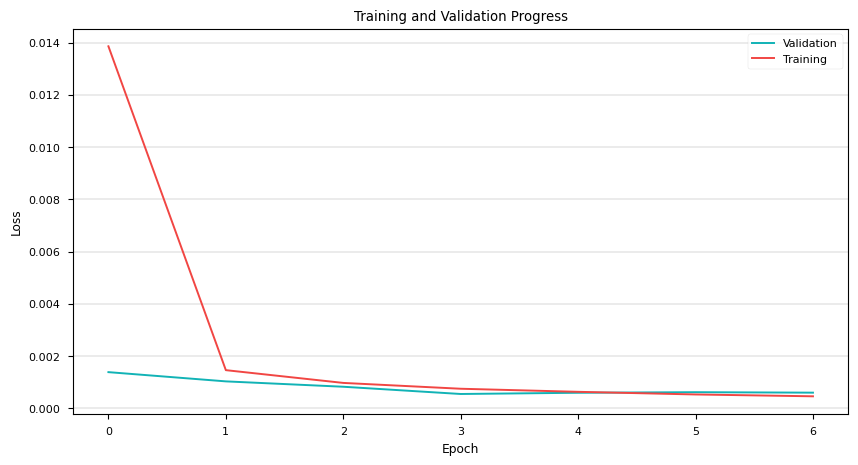

In [156]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": Transformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'pred_len': 3, 
        'output_attention': True,
        'd_model': 128,
        'enc_in': 2,
        'dec_in':2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 1,
        'd_layers': 1,
        'c_out': 2
    },
}
model = train(**params3)